# Segmentation Human Matting



In [ ]:
import glob
import time
import cv2
import matplotlib.pyplot as plt
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import os
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import random as r
from torchsummary import summary

In this project, we aim to develop an advanced image segmentation technique to accurately separate the subject of a person from an image and segment it from the background. The goal is to achieve precise segmentation results by combining semantic information and high-quality details using deep learning models. Unlike traditional keying techniques that only extract the character's outline, our approach focuses on understanding the semantic information of the character, leading to more accurate segmentation outcomes.

Our project involves comparing and enhancing the implementation details of various semantic segmentation models. We will explore lightweight network structures to implement different models for semantic segmentation. By utilizing these models, we aim to achieve efficient and accurate segmentation results in various scenarios.

Through this project, we seek to contribute to the field of image segmentation and improve the state-of-the-art techniques for separating subjects from images and extracting relevant information.



# Dataset


In this project, the dataset we use is the P3M10-k dataset, which is the largest, highest resolution, and most finely labelled public dataset of portrait keying known on the Internet (from the open-source project P3M ([dataset_link](https://www.google.com/url?q=https://github.com/JizhiziLi/P3M&sa=D&source=editors&ust=1689857044749260&usg=AOvVaw29d07Z2qXqfXXGM4sXCREs))). It contains 10000 anonymous high-resolution portrait images processed by facial blurring and their corresponding high-quality alpha-mask-labelled images. Our task is to randomly select 1000 images from the P3M-10k training set (9421 images) for training, 100 for validation and 100 for testing. Some images of the dataset are shown below:

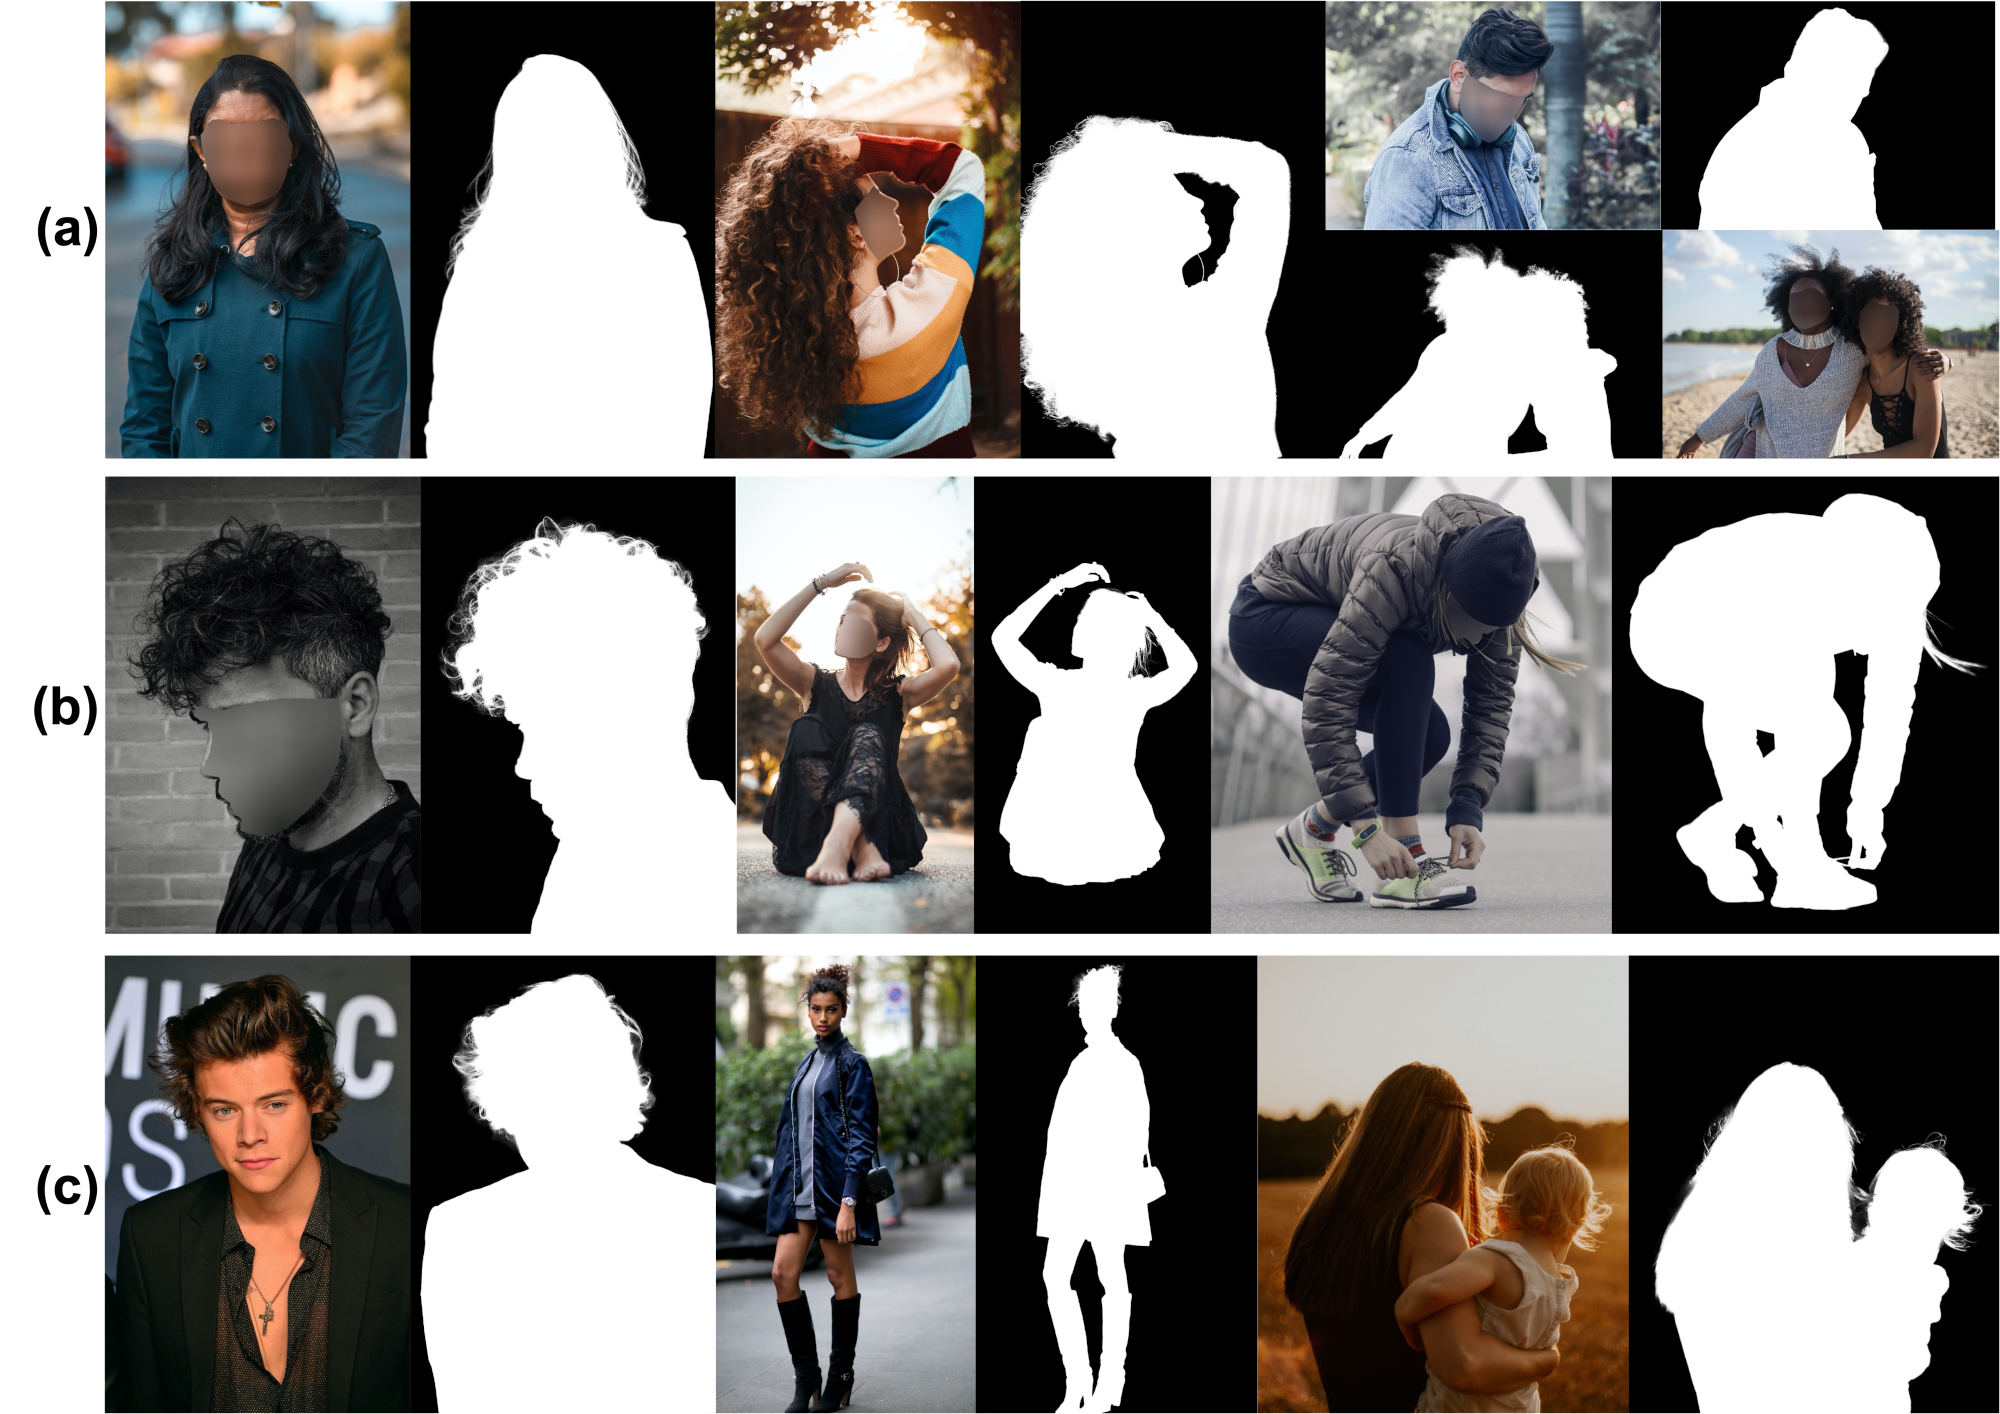

# Unet Intro

In this project we tried [U-Net](https://arxiv.org/abs/1505.04597) as out mainly network to complete the segmantation task.

As we mentioned above we can only train limited number of dataset because of lack of GPU equipment, whereas U-Net is a highly useful architecture when dealing with small datasets, particularly for medical image segmentation tasks, This is beacuse in the field of medical imaging, data is often limited and expensive to acquire,  making it crucial to address the challenges posed by the scarcity and size of the data.

Here's the structure of the U-Net:

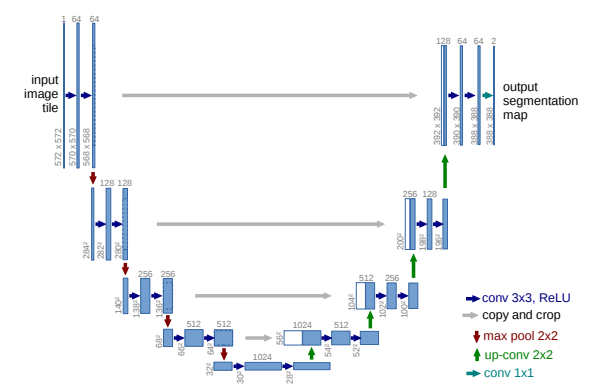

As we can see, U-Net's encoder-decoder structure with skip connections is highly effective for image segmentation tasks, even with small datasets. Its ability to capture both local and global context information, combined with the preservation of spatial details, enables accurate segmentation. U-Net serves as a powerful tool in the medical field, facilitating diagnosis, treatment decisions, and pathological analysis.

In our task, we use Mobilenet V2 as the encoder part of U-Net. And the U-Net decoder is responsible for upsampling and combining features from the MobileNetV2 backbone to obtain the final segmentation output.


# Mobilenet_v2 Introduction




[MobileNetV2](https://arxiv.org/abs/1801.04381) is a lightweight neural network architecture, particularly suitable for computer vision tasks on mobile and edge devices. It maintains high accuracy while keeping computational complexity low, made possible by a technique known as "Inverted Residuals."

Key innovations in MobileNetV2 include:

> Inverted Residuals

This is a novel network design where the "light" layers (such as 3x3 convolutions) are placed inside the "heavy" layers (like 1x1 convolutions), which reduces the computational complexity of the network.

> Linear Bottlenecks

In MobileNetV2, the authors used linear activations for designing the bottleneck layers of the model. This is based on the observation that ReLU nonlinear activations can cause a loss in the model's information entropy (i.e., richness of information). Thus, by using linear activations in the bottleneck layers, more information can be retained.

Reasons for using MobileNetV2 are as follows:

Efficient computational performance: MobileNetV2, due to its lightweight design, is suitable for use on devices with limited computational resources, such as mobile devices and embedded systems.

Adaptability to various tasks: MobileNetV2 can be applied to various computer vision tasks, including image classification, object detection, and semantic segmentation.



# Mobilenet_v2_backbone

Here is the network structure of Mobilenet_v2_base Unet:


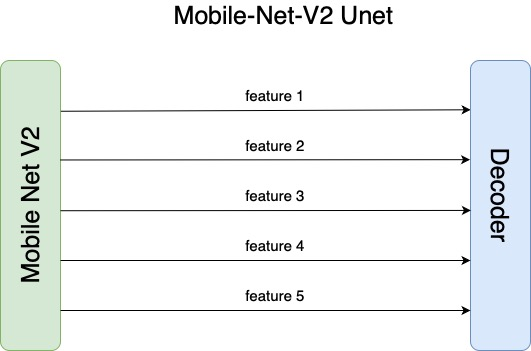


As we can see the MobileNetV2 architecture serves as the backbone for the U-Net model.
The backbone extracts hierarchical features from the input image, which are used in the U-Net decoder.

_make_divisible(v, divisor, min_value=None):

This function is used to round down a value v to the nearest number that can be evenly divided by divisor. However, the function makes sure the rounded value is not significantly smaller than the original value (no more than 10%). This function is used to ensure that the number of channels in each layer is a multiple of a specific value (divisor), which is often 8 for hardware efficiency.

In [ ]:
def _make_divisible(v, divisor, min_value=None):
	if min_value is None:
		min_value = divisor
	new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
	# Make sure that round down does not go down by more than 10%.
	if new_v < 0.9 * v:
		new_v += divisor
	return new_v


conv_bn(inp, oup, stride):

This function returns a sequential model with three layers: a convolutional layer (nn.Conv2d), a batch normalization layer (nn.BatchNorm2d), and a Rectified Linear Unit (ReLU) layer with a threshold of 6 (nn.ReLU6). This is a common building block in many CNN architectures, including MobileNetV2.

In [ ]:
def conv_bn(inp, oup, stride):
	return nn.Sequential(
		nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
		nn.BatchNorm2d(oup),
		nn.ReLU6(inplace=True)
	)

conv_1x1_bn(inp, oup):

defines a 1x1 convolution followed by batch normalization and a ReLU6 activation. This is often referred to as a pointwise convolution because it applies a single filter to each input channel

In [ ]:
def conv_1x1_bn(inp, oup):
	return nn.Sequential(
		nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
		nn.BatchNorm2d(oup),
		nn.ReLU6(inplace=True)
	)


This class defines an inverted residual block, which is the key architectural unit of MobileNetV2. The name "inverted residuals" refers to the fact that the shortcut connections are between the thin bottleneck layers, which is the opposite of what is done in traditional residual networks.

The InvertedResidual class is a PyTorch nn.Module and includes:

__init__: This method initializes the class and its variables. It accepts inp (number of input channels), oup (number of output channels), stride (stride value), expansion (expansion factor for the middle (bottleneck) layers), and dilation (kernel dilation).
forward: This method defines the forward pass of the model.
Here's a brief overview of the main steps:

If expansion equals to 1, the self.conv sequence is defined as depthwise convolution -> batch normalization -> ReLU6 -> pointwise convolution -> batch normalization.

If expansion is greater than 1, the self.conv sequence includes an additional initial pointwise convolution -> batch normalization -> ReLU6 prior to the depthwise convolution.

Depthwise separable convolutions are used to reduce the model size and complexity. They are a two-step process involving a depthwise convolution (which applies a single filter to each input channel) followed by a pointwise convolution (a 1x1 convolution) to combine the outputs.

The self.use_res_connect variable determines if a shortcut (residual) connection should be used. A residual connection is used if the stride is 1 and the input and output channels are the same. This is based on the idea that the learning process can be facilitated by providing alternate "short-cut" paths for the gradient to flow through.

During the forward pass (forward function), if a residual connection is to be used (self.use_res_connect == True), the input is added to the output of self.conv(x). If a residual connection is not used, the output of self.conv(x) is returned directly. The use of residual connections helps mitigate the problem of vanishing gradients during training.

In [ ]:
class InvertedResidual(nn.Module):
	def __init__(self, inp, oup, stride, expansion, dilation=1):
		super(InvertedResidual, self).__init__()
		self.stride = stride
		assert stride in [1, 2]

		hidden_dim = round(inp * expansion)
		self.use_res_connect = self.stride == 1 and inp == oup

		if expansion == 1:
			self.conv = nn.Sequential(
				# dw
				nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, dilation=dilation, bias=False),
				nn.BatchNorm2d(hidden_dim),
				nn.ReLU6(inplace=True),
				# pw-linear
				nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
				nn.BatchNorm2d(oup),
			)
		else:
			self.conv = nn.Sequential(
				# pw
				nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
				nn.BatchNorm2d(hidden_dim),
				nn.ReLU6(inplace=True),
				# dw
				nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, dilation=dilation, bias=False),
				nn.BatchNorm2d(hidden_dim),
				nn.ReLU6(inplace=True),
				# pw-linear
				nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
				nn.BatchNorm2d(oup),
			)

	def forward(self, x):
		if self.use_res_connect:
			return x + self.conv(x)
		else:
			return self.conv(x)

The code below defines the MobileNetV2 architecture in PyTorch. Here's a summary of the main parts:


This is where the architecture of the network is defined.
The first layer is a convolutional layer (with batch normalization and ReLU6), which takes as input the image (with in_channels channels) and outputs a feature map with input_channel channels.


The middle layers of the network consist of a series of "Inverted Residual Blocks". These blocks are built in a loop over the interverted_residual_setting list. Each entry in the list represents one block (or a set of identical blocks) with certain settings. For example, [expansion, 24, 2, 2] indicates a block with an expansion factor of expansion, output channels of 24, and it is repeated 2 times with a stride of 2 for the first layer of the block.

The last few layers of the network consist of a 1x1 convolutional layer (with batch normalization and ReLU6) and a fully connected layer that performs the final classification. There's also a dropout layer before the fully connected layer for regularizing the network and reducing overfitting.

Forward Propagation (forward): This function is where the forward pass of the network is defined. It feeds the input data through the layers defined in the initialization in the correct order.


Weight Initialization (_init_weights): This function initializes the weights of the different layers. Different types of layers are initialized in different ways. Convolutional and fully connected layers are initialized with a normal distribution (zero mean and a certain standard deviation), while the weights of the batch normalization layers are initialized with ones and the bias with zeros.

This architecture makes use of depthwise separable convolutions and linear bottlenecks (in the Inverted Residual Blocks) to reduce the computational cost and size of the network. This makes MobileNetV2 very efficient, especially for mobile and edge devices. The hyperparameters like alpha (width multiplier) and expansion (expansion factor of the inverted residuals) allow for further trade-offs between computational cost and accuracy.

In [ ]:
class MobileNetV2(nn.Module):
	def __init__(self, in_channels, alpha=1.0, expansion=6, num_classes=1000):
		super(MobileNetV2, self).__init__()
		self.in_channels = in_channels
		self.num_classes = num_classes
		input_channel = 32
		last_channel = 1280
		interverted_residual_setting = [
			# t, c, n, s
			[1        , 16, 1, 1],
			[expansion, 24, 2, 2],
			[expansion, 32, 3, 2],
			[expansion, 64, 4, 2],
			[expansion, 96, 3, 1],
			[expansion, 160, 3, 2],
			[expansion, 320, 1, 1],
		]

		# building first layer
		input_channel = _make_divisible(input_channel*alpha, 8)
		self.last_channel = _make_divisible(last_channel*alpha, 8) if alpha > 1.0 else last_channel
		self.features = [conv_bn(self.in_channels, input_channel, 2)]

		# building inverted residual blocks
		for t, c, n, s in interverted_residual_setting:
			output_channel = _make_divisible(int(c*alpha), 8)
			for i in range(n):
				if i == 0:
					self.features.append(InvertedResidual(input_channel, output_channel, s, expansion=t))
				else:
					self.features.append(InvertedResidual(input_channel, output_channel, 1, expansion=t))
				input_channel = output_channel

		# building last several layers
		self.features.append(conv_1x1_bn(input_channel, self.last_channel))

		# make it nn.Sequential
		self.features = nn.Sequential(*self.features)

		# building classifier
		if self.num_classes is not None:
			self.classifier = nn.Sequential(
				nn.Dropout(0.2),
				nn.Linear(self.last_channel, num_classes),
			)

		# Initialize weights
		self._init_weights()

	def forward(self, x):
		# Stage1
		x = self.features[0](x)
		x = self.features[1](x)
		# Stage2
		x = self.features[2](x)
		x = self.features[3](x)
		# Stage3
		x = self.features[4](x)
		x = self.features[5](x)
		x = self.features[6](x)
		# Stage4
		x = self.features[7](x)
		x = self.features[8](x)
		x = self.features[9](x)
		x = self.features[10](x)
		x = self.features[11](x)
		x = self.features[12](x)
		x = self.features[13](x)
		# Stage5
		x = self.features[14](x)
		x = self.features[15](x)
		x = self.features[16](x)
		x = self.features[17](x)
		x = self.features[18](x)

		# Classification
		if self.num_classes is not None:
			x = x.mean(dim=(2,3))
			x = self.classifier(x)

		# Output
		return x

	def _init_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
				m.weight.data.normal_(0, math.sqrt(2. / n))
				if m.bias is not None:
					m.bias.data.zero_()
			elif isinstance(m, nn.BatchNorm2d):
				m.weight.data.fill_(1)
				m.bias.data.zero_()
			elif isinstance(m, nn.Linear):
				n = m.weight.size(1)
				m.weight.data.normal_(0, 0.01)
				m.bias.data.zero_()

This class MobileNetV2Backbone serves as a backbone network utilizing MobileNetV2, output intermediate feature maps which are used in the skip connections in Unet.

The MobileNetV2Backbone class has the following main components:



> Initialization (__init__)



This is where the MobileNetV2 model is instantiated, without the classification layer (as specified by num_classes=None).


> Forward Propagation (forward)


We set this function returning the output of intermediate layers of the network. These intermediate layers' outputs are feature maps at various scales (enc2x, enc4x, enc8x, enc16x, enc32x). And these feature maps will be used in the skip connection in Unet.


> Pretrained Model Loading (load_pretrained_ckpt):




This function loads a pretrained model .



In [ ]:
class MobileNetV2Backbone(nn.Module):
    """ MobileNetV2 Backbone
    """

    def __init__(self, in_channels):
        super(MobileNetV2Backbone, self).__init__()
        self.in_channels = in_channels

        self.model = MobileNetV2(self.in_channels, alpha=1.0, expansion=6, num_classes=None)
        self.enc_channels = [16, 24, 32, 96, 1280]

    def forward(self, x):
        # x = reduce(lambda x, n: self.model.features[n](x), list(range(0, 2)), x)
        x = self.model.features[0](x)
        x = self.model.features[1](x)
        enc2x = x

        # x = reduce(lambda x, n: self.model.features[n](x), list(range(2, 4)), x)
        x = self.model.features[2](x)
        x = self.model.features[3](x)
        enc4x = x

        # x = reduce(lambda x, n: self.model.features[n](x), list(range(4, 7)), x)
        x = self.model.features[4](x)
        x = self.model.features[5](x)
        x = self.model.features[6](x)
        enc8x = x

        # x = reduce(lambda x, n: self.model.features[n](x), list(range(7, 14)), x)
        x = self.model.features[7](x)
        x = self.model.features[8](x)
        x = self.model.features[9](x)
        x = self.model.features[10](x)
        x = self.model.features[11](x)
        x = self.model.features[12](x)
        x = self.model.features[13](x)
        enc16x = x

        # x = reduce(lambda x, n: self.model.features[n](x), list(range(14, 19)), x)
        x = self.model.features[14](x)
        x = self.model.features[15](x)
        x = self.model.features[16](x)
        x = self.model.features[17](x)
        x = self.model.features[18](x)
        enc32x = x
        return [enc2x, enc4x, enc8x, enc16x, enc32x]

    def load_pretrained_ckpt(self):
        # the pre-trained model is provided by https://github.com/thuyngch/Human-Segmentation-PyTorch
        ckpt_path = '/content/drive/MyDrive/pre_train/mobilenetv2_human_seg.ckpt'
        if not os.path.exists(ckpt_path):
            print('cannot find the pretrained mobilenetv2 backbone')
            exit()

        ckpt = torch.load(ckpt_path)
        self.model.load_state_dict(ckpt)

# Realization of Mobilenet_v2_Unet


The mv2_unet class builds an architecture that combines MobileNetV2 and the U-Net architecture. Here is the basic breakdown:

Initialization (__init__):

This is where we initialize the layers of your network. The model is divided into two parts - the encoder (feature extractor) and the decoder. The encoder uses the MobileNetV2Backbone architecture, and the decoder is a set of up-convolution and fusion layers that form the U-Net architecture.

Forward (forward):

This is where we define how the data flows through your network. The data first goes through the encoder and then through the decoder. The output from each step of the encoder is stored and added to the output of each corresponding step in the decoder. This is the 'skip connection' feature of U-Net architecture which helps in precise localization in the output.
_initialize_weights: This method initializes weights for the convolutional layers using kaiming normal initialization, and sets the biases to zero. This is usually done to avoid vanishing/exploding gradients issues.

freeze_backbone and unfreeze_backbone:

These methods freeze and unfreeze the weights of the backbone (MobileNetV2) respectively. Freezing the backbone is useful when want to fine-tune only the decoder part of the model while keeping the backbone as it is. Unfreezing is useful when training the entire model including the backbone.

freeze and unfreeze: These methods freeze and unfreeze the weights of the entire model respectively.

In summary, we combines the efficient feature extraction capabilities of MobileNetV2 with the effective precise localization capabilities of the U-Net architecture in this model.

In [ ]:
class mv2_unet(nn.Module):
    '''
        mobilenet v2 + unet

    '''
    def __init__(self, classes=3,pretrain=True):

        super(mv2_unet, self).__init__()
        # -----------------------------------------------------------------
        # encoder
        # ---------------------
        #self.feature = mobilenet_v2()
        self.feature = MobileNetV2Backbone(in_channels=3)
        if pretrain:
            self.feature.load_pretrained_ckpt()
        # -----------------------------------------------------------------
        # decoder
        # ---------------------

        self.s5_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(1280, 96, 3, 1, 1),
                                        nn.BatchNorm2d(96),
                                        nn.ReLU())
        self.s4_fusion = nn.Sequential(nn.Conv2d(96, 96, 3, 1, 1),
                                       nn.BatchNorm2d(96))

        self.s4_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(96, 32, 3, 1, 1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU())
        self.s3_fusion = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                       nn.BatchNorm2d(32))

        self.s3_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(32, 24, 3, 1, 1),
                                        nn.BatchNorm2d(24),
                                        nn.ReLU())
        self.s2_fusion = nn.Sequential(nn.Conv2d(24, 24, 3, 1, 1),
                                       nn.BatchNorm2d(24))

        self.s2_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(24, 16, 3, 1, 1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU())
        self.s1_fusion = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1),
                                       nn.BatchNorm2d(16))

        self.last_conv = nn.Conv2d(16, classes, 3, 1, 1)
        self.last_up = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, input):

        # -----------------------------------------------
        # encoder
        # ---------------------
        s1, s2, s3, s4, s5 = self.feature(input)
        # -----------------------------------------------
        # decoder
        # ---------------------
        s4_ = self.s5_up_conv(s5)
        s4_ = s4_ + s4
        s4 = self.s4_fusion(s4_)

        s3_ = self.s4_up_conv(s4)
        s3_ = s3_ + s3
        s3 = self.s3_fusion(s3_)

        s2_ = self.s3_up_conv(s3)
        s2_ = s2_ + s2
        s2 = self.s2_fusion(s2_)

        s1_ = self.s2_up_conv(s2)
        s1_ = s1_ + s1
        s1 = self.s1_fusion(s1_)

        out = self.last_up(self.last_conv(s1))

        return out

    def _initialize_weights(self, *stages):
        for modules in stages:
            for module in modules.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()

    def freeze_backbone(self):
        for param in self.feature.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):

        for param in self.feature.parameters():
            param.requires_grad = True
    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False
    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad=True

In [ ]:
net=mv2_unet()
summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

# Data Augmentation

To improve the performance of our deep learning models, we use data augmentation techniques. Data augmentation is a commonly used technique in machine learning and deep learning tasks to augment the training dataset, which generates new samples by performing a series of random transformations and expansion operations on the original data. The benefits of data augmentation are:





1. Reduces the cost of data collection and data labelling
2. Improving model generalisation by giving more variety and flexibility to the model
3. Improves model accuracy in prediction as it uses more data to train the model
4. Reduces overfitting of data
5. Deals with imbalances in the dataset by increasing the number of samples in a few classes

The main data enhancement operations we use in our project are: random rotation, random cropping, random zoom-in and zoom-out, type conversion.

In [ ]:
input_size=256
train_txt='/content/drive/MyDrive/Colab Notebooks/P3M_demo.txt'
var_txt='/content/drive/MyDrive/P3M_var.txt'

The 1000-sheet training set (P3M_demo.txt) and 100-sheet validation set (P3M_var.txt) that we used are shown below:

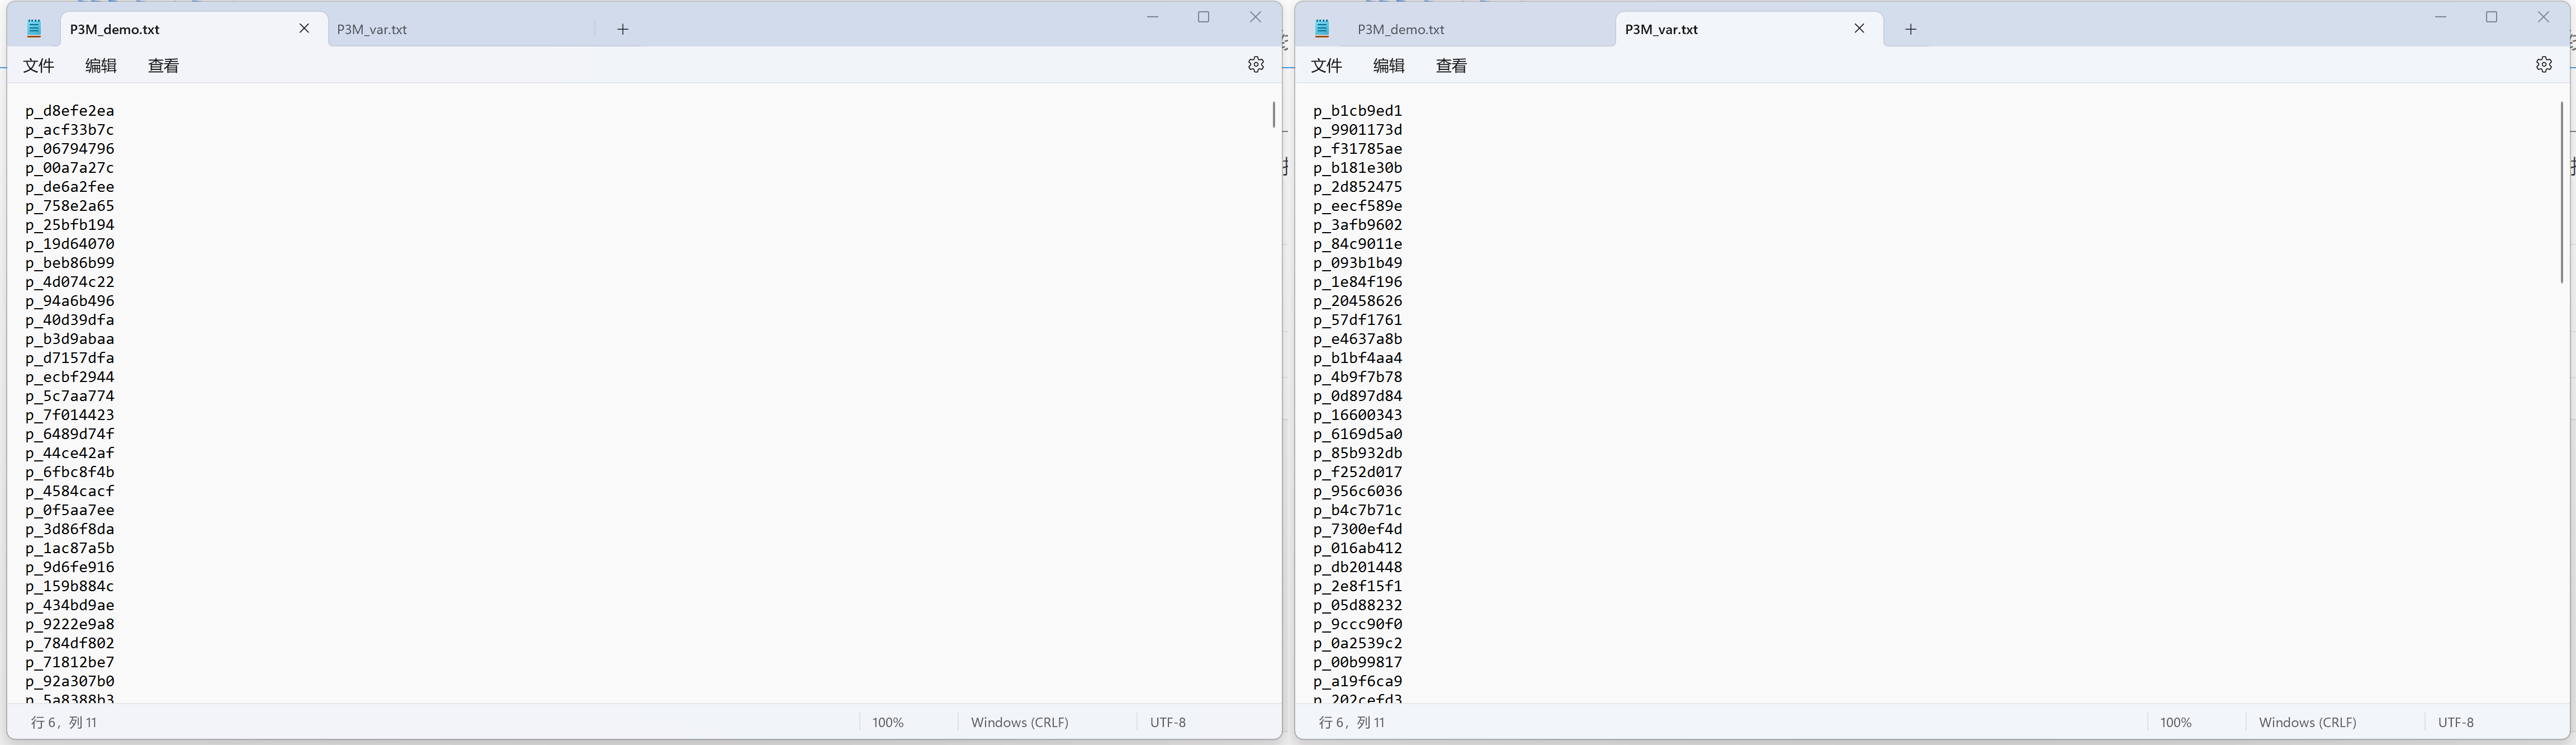

The code to randomly zoom in/out and then randomly crop the image is shown below:

In [ ]:
def random_scale_and_creat_patch(image, alpha, patch_size):

    randi = 0.5  # original = 0.5
    if r.random() < randi:
        h, w, c = image.shape
        scale = 0.75 + 0.5 * r.random()
        image = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_CUBIC)
        alpha = cv2.resize(alpha, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_NEAREST)
        #alpha = cv2.resize(alpha, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_CUBIC)

        # creat patch
    if r.random() < randi:
        h, w, c = image.shape
        if h > patch_size and w > patch_size:#cropping

            xgap = w - patch_size
            ygap = h - patch_size

            x = r.randrange(0, xgap)
            y = r.randrange(0, ygap)
            image = image[y:y + patch_size, x:x + patch_size, :]
            alpha = alpha[y:y + patch_size, x:x + patch_size, :]
            #alpha = alpha[y:y + patch_size, x:x + patch_size, :]
        else:
            image = cv2.resize(image, (patch_size, patch_size), interpolation=cv2.INTER_CUBIC)
            alpha = cv2.resize(alpha, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)
           # alpha = cv2.resize(alpha, (patch_size, patch_size), interpolation=cv2.INTER_CUBIC)
    else:
        image = cv2.resize(image, (patch_size, patch_size), interpolation=cv2.INTER_CUBIC)
        alpha = cv2.resize(alpha, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)
       # alpha = cv2.resize(alpha, (patch_size, patch_size), interpolation=cv2.INTER_CUBIC)

    return image, alpha


The code for random horizontal/vertical flipping is shown below as in the figure below:

In [ ]:
def random_flip(image, alpha):

    if r.random() < 0.5:
        image = cv2.flip(image, 0)
        alpha = cv2.flip(alpha, 0)
       # alpha = cv2.flip(alpha, 0)

    if r.random() < 0.5:
        image = cv2.flip(image, 1)
        alpha = cv2.flip(alpha, 1)
        #alpha = cv2.flip(alpha, 1)
    return image, alpha

The code to convert the input NumPy array into a PyTorch tensor (Tensor) is shown below:

In [ ]:
def np2Tensor(array):

    ts = (2, 0, 1)
    #print(len(array.shape))


    tensor = torch.FloatTensor(array.transpose(ts).astype(float))

    # img = torch.Tensor(img / 255.0)
    #print("img",tensor.shape)
    # img = img.unsqueeze(0)
    return tensor

We define a custom PyTorch dataset class, P3M, for loading and processing data related to the character keying task. It provides data reading, preprocessing, and transformation functions to provide data support for training and evaluating models. The code is shown below:

In [ ]:
import torch.utils.data as data
class P3M(data.Dataset):
    """
    human_matting
    """

    def __init__(self, root_dir, imglist, patch_size):
        super().__init__()
        self.data_root = root_dir

        self.patch_size = patch_size
        with open(imglist) as f:
            self.imgID = f.readlines()
        self.num = len(self.imgID)
        print("Dataset : file number %d"% self.num)

    def read_files(self,file_name={}):

        image_name = os.path.join("/content/drive/MyDrive/Colab Notebooks/P3M-10k/train","blurred_image", file_name['image'])
        alpha_name = os.path.join('/content/drive/MyDrive/Colab Notebooks/P3M-10k/train',"mask", file_name['alpha'])

        alpha = cv2.imread(alpha_name)

        image = cv2.imread(image_name)

        # alpha = cv2.imread(alpha_name)
        if image is None or alpha is None:
            while True:
                print(alpha_name)
        return image,alpha

    def __getitem__(self, index):
        #assert index <= len(self),'index range error'
        # read files
        image, alpha = self.read_files(file_name={'image': self.imgID[index].strip()+'.jpg',
                                'alpha': self.imgID[index].strip() +'.png'
                                                     })

        alpha[alpha <128] = 0
        alpha[alpha >=128] = 1
        image, alpha = random_scale_and_creat_patch(image, alpha,  self.patch_size)

        image, alpha= random_flip(image, alpha)


        # normalize
        image = (image.astype(np.float32)  - (114., 121., 134.,)) / 255.0

        alpha = alpha.astype(np.float32)


        # to tensor
        image = np2Tensor(image)
        # print(trimap.shape)

        alpha = np2Tensor(alpha)


        sample = {'image': image, 'alpha': alpha}

        return sample

    def __len__(self):
        return self.num

# Loss for Unet


We tried two different losses function in our group project. One is BinaryCrossEntropy, another one is CrossEntropy. Both of them is used for
classification tasks. And theoretically, BCE is more suitable for our project, but after several trials, using the CrossEntropy loss function seems have a better performance than using BCE.


In [ ]:
def loss_function_for_Unet(args, alpha_pre, alpha_gt):
    # -------------------------------------
    # classification loss
    # ------------------------
    # criterion = nn.BCELoss()
    # alpha_pre = alpha_pre.contiguous().view(-1)
    # alpha_gt = alpha_gt.view(-1)
    # loss = criterion(alpha_pre, alpha_gt)
    criterion = nn.CrossEntropyLoss()

    loss = criterion(alpha_pre, alpha_gt[:, 0, :, :].long())

    return loss

# Training

This code defines a class unet_train_args that contains various parameters used for training a U-Net model. Here's a brief explanation of these parameters:

dataDir: The path where the training data is stored.

saveDir: The path where the model will be saved.

trainList: The path to the list of training datasets.

vaList: The path to the list of validation datasets.

load: The preset name of the model to load.

finetuning: A boolean flag indicating whether restoring training.

without_gpu: A boolean flag indicating whether training should be performed without a GPU.

nThreads: The number of threads to use for data loading.

train_batch: The batch size for training.

patch_size: The size of the patches to be used for training.

freeze_epoch: The number of epochs after which the learning rate should be decreased.
lr: The initial learning rate.

lrDecay: The number of epochs after which the learning rate should be decayed.

lrdecayType: The type of learning rate decay to use ('step' or 'keep').

nEpochs: The total number of epochs for which training should be performed.

save_epoch: The number of epochs after which the model should be saved.
gpus: The ID of the GPU to use for training.

In [ ]:
class unet_train_args():
  def __init__(self,saveDir='./ckpt',trainList='/content/drive/MyDrive/Colab Notebooks/P3M_demo.txt',) :
       self.dataDir='/content/drive/MyDrive/Colab Notebooks/P3M-10k/train'
       self.saveDir=saveDir
       self.trainList=trainList
       self.vaList='/content/drive/MyDrive/P3M_var.txt'
       self.load='unet'
       self.finetuning=False
       self.without_gpu=True
       self.nThreads=0
       self.train_batch=2
       self.patch_size=256
       self.freeze_epoch=20
       self.lr=1e-4
       self.lrDecay=25
       self.lrdecayType = 'step' #'keep' or 'step'
       self.nEpochs=40
       self.save_epoch=1
       self.gpus='0'

The function unet_get_args() creates an instance of the unet_train_args class and returns it. This instance, called args, holds the training settings that were defined in the unet_train_args class.

In [ ]:

def unet_get_args():
    # Training settings
    args=unet_train_args()
    return args

The set_lr function is a utility for updating the learning rate of our model's optimizer over the course of training.
After every lrDecay epochs, the learning rate is halved.



In [ ]:
def set_lr(args, epoch, optimizer):

    lrDecay = args.lrDecay

    epoch_iter = (epoch + 1) // lrDecay
    lr = args.lr / 2**epoch_iter


    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

The Train_Log class encapsulates functionality for logging training process, saving and loading models during training.



In [ ]:
class Train_Log():
    def __init__(self, args):
        self.args = args

        self.save_dir = os.path.join(args.saveDir, args.load)
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

        self.save_dir_model = os.path.join(self.save_dir, 'model')
        if not os.path.exists(self.save_dir_model):
            os.makedirs(self.save_dir_model)

        if os.path.exists(self.save_dir + '/log.txt'):
            self.logFile = open(self.save_dir + '/log.txt', 'a')
        else:
            self.logFile = open(self.save_dir + '/log.txt', 'w')


    def save_model(self, model, epoch):

        lastest_out_path = "{}/param.pth".format(self.save_dir_model)
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
        }, lastest_out_path,_use_new_zipfile_serialization=False)

        model_out_path = "{}/model_obj.pth".format(self.save_dir_model)
        torch.save(
            model,
            model_out_path,_use_new_zipfile_serialization=False)

    def load_model(self, model):
        lastest_out_path = "{}/param.pth".format(self.save_dir_model)
        ckpt = torch.load(lastest_out_path)
        start_epoch = ckpt['epoch']
        model.load_state_dict(ckpt['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})".format(lastest_out_path, ckpt['epoch']))

        return start_epoch, model

    def save_log(self, log):
        self.logFile.write(log + '\n')


Here is what we've done in the train function:



> Args and Environment Initialization:



 The function first gets training arguments by calling the unet_get_args function. It then checks whether to use a CPU or a GPU for training. If args.without_gpu is set to True, the function uses the CPU for training; otherwise, it checks if a GPU is available.



> Model Setup:


 The model is moved to the selected device (CPU or GPU).


> Dataset Loading:


 The function loads the training and validation datasets by calling the P3M class and using DataLoader to create iterable dataloaders for training and validation.


> Optimizer Setup:

An Adam optimizer is initialized with model parameters that require gradient computation. The learning rate is specified by args.lr, and the betas and weight decay parameters are set to 0.9, 0.999, and 0.0005, respectively.




> Model Training:

 The function enters the training loop where it runs for a number of epochs specified by args.nEpochs. The training steps include setting the learning rate, iterating over the training data, computing the loss, performing backpropagation, and updating the model parameters. If args.finetuning is True, the function loads the pre-trained model and continues training from the epoch where it was left off.


> Model Evaluation:


 After every epoch, the function evaluates the model on the validation set. This involves forwarding the validation data through the model, computing the loss, and then accumulating this loss to calculate the average validation loss.



> Model Saving:

If the current epoch is divisible by args.save_epoch, the average training and validation losses are computed, logged, and saved to a file. The model is also saved.



In [ ]:
def unet_train(model):
    print("=============> Loading arguments")
    args = unet_get_args()

    print("============> Initializing environment")
    if args.without_gpu:
        print("Using CPU!")
        device = torch.device('cpu')
    else:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            print("No GPU is available!")

    print("============> Building model...")
    model.to(device)

    print("============> Loading datasets...")
    train_data = P3M(root_dir=args.dataDir, imglist=args.trainList, patch_size=args.patch_size)
    trainloader = DataLoader(train_data, batch_size=args.train_batch, drop_last=True, shuffle=True, num_workers=args.nThreads, pin_memory=True)

    validation_data = P3M(root_dir=args.dataDir, imglist=args.vaList, patch_size=args.patch_size)
    valoader = DataLoader(validation_data, batch_size=args.train_batch, drop_last=True, shuffle=True, num_workers=args.nThreads, pin_memory=True)

    print("============> Setting optimizer...")
    lr = args.lr
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, betas=(0.9, 0.999), weight_decay=0.0005)

    print("============> Starting training...")
    start_epoch = 1
    trainlog = Train_Log(args)
    if args.finetuning:
        start_epoch, model = trainlog.load_model(model)
        start_epoch+=1

    model.train()
    total_step=len(trainloader)
    if args.freeze_epoch>start_epoch:
        print("============> Freezing Backbone...")
        model.freeze_backbone()
    for epoch in range(start_epoch, args.nEpochs + 1):
        if epoch==args.freeze_epoch:
            print("============> Unfreezing Backbone...")
            model.unfreeze_backbone()
        loss_ = 0
        vloss_ = 0
        if args.lrdecayType != 'keep':
            lr = set_lr(args, epoch, optimizer)
        pbar = enumerate(trainloader)
        pbar = tqdm(pbar, total=total_step)
        t0 = time.time()
        model.train()
        for i, sample_batched in pbar:
            # Gradient descent method to minimize loss and update optimizer parameters
            img, trimap_gt = sample_batched['image'], sample_batched['alpha']
            img, trimap_gt = img.to(device), trimap_gt.to(device)
            trimap_pre = model(img)
            loss = loss_function_for_Unet(args, trimap_pre, trimap_gt)
            optimizer.zero_grad()
            loss.backward() # Update parameters based on loss
            optimizer.step()
            loss_ += loss.item()

        print("============> Validation...")
        pbar = enumerate(valoader)
        vtotal_step = len(valoader)
        pbar = tqdm(pbar, total=vtotal_step)
        model.eval()
        for j, sample_batched in pbar:
            img, trimap_gt = sample_batched['image'], sample_batched['alpha']
            img, trimap_gt = img.to(device), trimap_gt.to(device)
            trimap_pre = model(img)
            loss = loss_function_for_Unet(args, trimap_pre, trimap_gt)
            vloss_ += loss.item()
        if epoch % args.save_epoch == 0:
            loss_ = loss_ / (i + 1)
            vloss_ = vloss_/(j+1)
            log = "[{} / {}] \tLearning Rate: {:.6f}\n Training Loss: {:.5f}\n Validation Loss: {:.5f}\t".format(epoch, args.nEpochs, lr, loss_, vloss_)
            print(log)
            trainlog.save_log(log)
            trainlog.save_model(model, epoch)


In [ ]:
torch.set_grad_enabled(True)
model = mv2_unet(classes=2)
unet_train(model)

=============> Loading args
============> Environment init
use CPU !
============> Building model ...
============> Loading datasets ...
Dataset : file number 999
Dataset : file number 100
============> Set optimizer ...
============> Start Train ! ...
============> Freeze Backbone ...


  0%|          | 2/499 [00:04<16:49,  2.03s/it]


KeyboardInterrupt: ignored

# Test & Show Result

After finishing the training of the U-Net model, we calculated the average validation loss for the training set and validation set as shown below:

We define a class called Unet_Test_args and an instance of the class, args, to be used during Unet testing to set and pass parameters and configuration information during Unet testing.
After that we defined a function named show_losses for displaying the loss result image, which operates by reading the image file, colour channel conversion and image display using the Matplotlib library.

From the picture we can see that the average loss fluctuates, mainly due to the following reasons.
1. The U-Net model has only been trained for forty generations.
2. The training equipment is not very good.

In [ ]:
class Unet_Test_args():
  def __init__(self):
    self.model='/content/drive/MyDrive/ckpt_Unet/unet/param.pth'
    self.loss_result='/content/drive/MyDrive/ckpt_Unet/unet_with_aspp/Losses_over_epoches_with_avg.png'
    self.size=256
    self.without_gpu=True
    self.pic_path='/content/drive/MyDrive/gg.jpg'
    self.test_pic_path='/content/drive/MyDrive/test.txt'
    self.net=mv2_unet(classes=2)
args=Unet_Test_args()

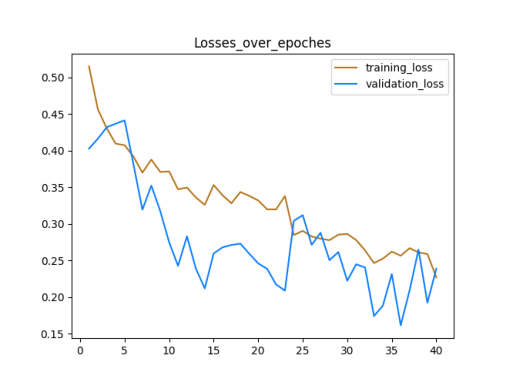

In [ ]:
def show_losses():
  loss=cv2.imread(args.loss_result)
  cv2.cvtColor(loss,cv2.COLOR_BGR2RGB)
  plt.imshow(loss)
  plt.axis('off')
  plt.show()
show_losses()

We define the function load_model (to load the model and move it to the specified device for inference) and the function unet_test_one_pic (for testing and predicting the U-Net model on a single image). In function unet_test_one_pic, we process the input by loading the model and passing it to the network to process the image data, in this phase by performing softmax normalisation on the categories and then taking the category with the highest probability as the prediction result and displaying the three resultant images, which are:
1. original image
2. Network output image (bipartite image), 0 is black, 255 is white
3. the network outputs a hybrid image multiplied with the original image, set to 0 and 1, and the 1 part is saved

In [ ]:
if args.without_gpu:
    print("use CPU !")
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        n_gpu = torch.cuda.device_count()
        print("----------------------------------------------------------")
        print("|       use GPU !      ||   Available GPU number is {} !  |".format(n_gpu))
        print("----------------------------------------------------------")

        device = torch.device('cuda:0,1')

use CPU !


In [ ]:
def load_model(args):
    print('Loading model from {}...'.format(args.model))
    if args.without_gpu:

        #myModel = torch.load(args.model, map_location=lambda storage, loc: storage)
        ckpt = torch.load(args.model)
        args.net.load_state_dict(ckpt['state_dict'])
        myModel=args.net
    else:
        myModel = torch.load(args.model)
    #print(myModel)
    myModel.eval()
    myModel.to(device)
    # print(
    #     torchsummary((3,160,160),myModel)
    # )
    # myModel.cuda()

    return myModel

Loading model from /content/drive/MyDrive/ckpt_Unet/unet/param.pth...


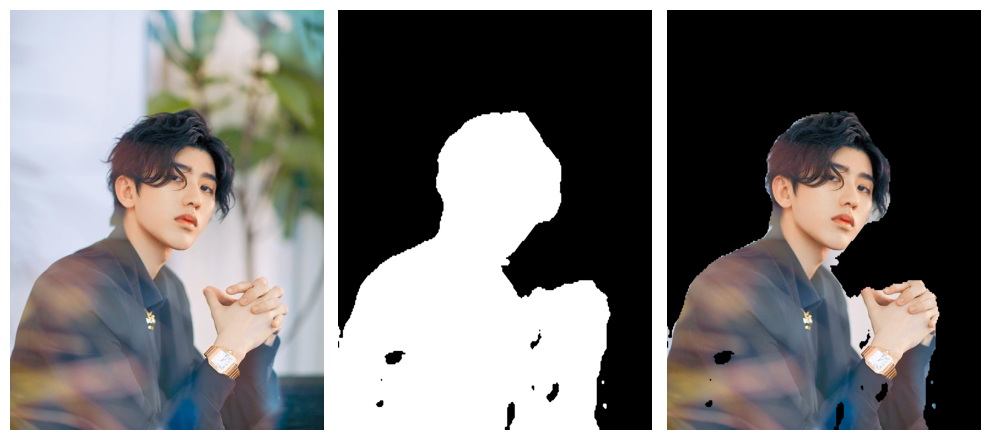

In [ ]:
def unet_test_one_pic():
  torch.set_grad_enabled(False)
  net=load_model(args)
  image=cv2.imread(args.pic_path)
  origin_h, origin_w, c = image.shape
  image_resize = cv2.resize(image, (args.size, args.size), interpolation=cv2.INTER_CUBIC)
  image_resize = (image_resize - (114., 121., 134.,)) / 255.0  # normalization,104., 112., 121.,

  tensor_4D = torch.FloatTensor(1, 3, args.size, args.size)

  tensor_4D[0, :, :, :] = torch.FloatTensor(image_resize.transpose(2, 0, 1))
  inputs = tensor_4D.to(device)
  alpha = net(inputs)
  pr = F.softmax(alpha[0].permute(1, 2, 0), dim=-1).cpu().numpy().argmax(axis=-1)
  imag=cv2.resize(np.uint8(pr), (origin_w, origin_h), interpolation=cv2.INTER_CUBIC)

  pr=cv2.cvtColor(np.asarray(imag),cv2.COLOR_RGB2BGR)
  pre_image=pr.copy()
  image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
  pre_image= np.multiply(pre_image, image)
  #pr_image=cv2.cvtColor(pre_image,cv2.COLOR_BGR2RGB)

  fig, axs = plt.subplots(1, 3, figsize=(10, 5))
  axs[0].imshow(image)
  axs[0].axis('off')
  axs[1].imshow(pr*255)
  axs[1].axis('off')
  axs[2].imshow(pre_image)
  axs[2].axis('off')
  plt.tight_layout()

  plt.show()
unet_test_one_pic()

Here, we need to calculate the Mean Intersection over Union (mIoU) and accuracy of the binary segmentation network with the following information:
1. Predictions: the output of the binary segmentation network, usually a binary image, indicating whether each pixel belongs to the positive or negative category.
2. Ground Truth: the true label image corresponding to the prediction result, which is also a binary image with the same size as the prediction result.

Intersection over Union (IoU): IoU is a measure of the degree of overlap between predicted results and true labels. The IoU formula is as follows:

  IoU = TP / (TP + FP + FN)

Where TP (True Positive) indicates the number of pixels correctly predicted as positive examples of classification, FP (False Positive) indicates the number of pixels incorrectly predicted as positive examples of classification, TN (True Negative) is the number of pixels predicted to be in the negative category and correctly predicted, and FN (False Negative) indicates the number of pixels incorrectly predicted as positive examples of classification. belonging to the negative category.

The general steps for calculating mIoU are as follows: for each category, calculate the IoU: for category c, calculate the IoU of category c by counting the predicted results as well as the number of intersections and the number of combinations of pixels belonging to category c in the actual labels, i.e., the number of intersections divided by the number of combinations. The formula for mIoU is as follows:

mIoU = (IoU_1 + IoU_2 + ... + IoU_n) / n

Where, IoU_1, IoU_2, ... IoU_n represent the IoU values of category 1, category 2, ... IoU_1, IoU_2, ..., IoU_n represent the IoU values of category 1, category 2, ..., category n respectively, n represents the number of categories.



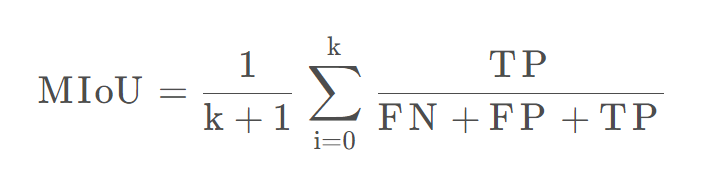

Firstly, we define the function calculate_iou to calculate the intersection and concurrency ratio (IoU) between the given predicted labels and the true labels and then calculate the mIoU. The function calculate_accuracy is used to calculate the accuracy and the function get_predictions is used to get the predicted labels of the given image and it inputs the image into the network to get the Predictions (The predicted labelled image has two channels where channel 0 represents the background category and channel 1 represents the person category, the probability of each pixel is converted to the final category label using the operation of argmax(axis=-1) and the channel with the highest probability is taken as the prediction). Finally, the function test_unet_miou performs the test of mIoU and accuracy and performs the output, the code is shown below:

In [ ]:
def calculate_iou(pred_labels, true_labels):
    intersection = np.logical_and(pred_labels, true_labels)
    union = np.logical_or(pred_labels, true_labels)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [ ]:
def calculate_mIoU(pred_labels, true_labels):
    num_classes = 2
    iou_list = []
    for class_id in range(num_classes):
        pred_class = pred_labels == class_id
        true_class = true_labels == class_id
        iou = calculate_iou(pred_class, true_class)
        iou_list.append(iou)
    mIoU = np.mean(iou_list)
    return mIoU

In [ ]:
def calculate_accuracy(pred_labels, true_labels):
    accuracy = np.sum(pred_labels == true_labels) / pred_labels.size
    return accuracy

In [ ]:
def get_predictions(net,image):
    origin_h, origin_w, c = image.shape
    image_resize = cv2.resize(image, (input_size, input_size), interpolation=cv2.INTER_CUBIC)
    image_resize = (image_resize - (114., 121., 134.,)) / 255.0  # normalization,104., 112., 121.,

    tensor_4D = torch.FloatTensor(1, 3, input_size, input_size)

    tensor_4D[0, :, :, :] = torch.FloatTensor(image_resize.transpose(2, 0, 1))
    inputs = tensor_4D.to(device)

    alpha = net(inputs)
    # print(trimap)
    pr = F.softmax(alpha[0].permute(1, 2, 0), dim=-1).cpu().numpy().argmax(axis=-1)
    pr=cv2.resize(pr,(origin_w,origin_h),interpolation=cv2.INTER_NEAREST)
    return pr

In [ ]:
def test_unet_miou():
    myModel = load_model(args)
    with open(args.test_pic_path) as f:
        imgID = f.readlines()
    num = len(imgID)
    total_imou=0
    accuracy=0
    print("Dataset : file number %d" % num)
    par=enumerate(imgID)
    par=tqdm(par,total=num)
    for i,img in par:
        image_name = os.path.join("/content/drive/MyDrive/Colab Notebooks/P3M-10k/train","blurred_image", img[:-1]+'.jpg')
        alpha_name = os.path.join('/content/drive/MyDrive/Colab Notebooks/P3M-10k/train',"mask",img[:-1]+'.png')
        #print(alpha_name)
        alpha = cv2.imread(alpha_name,cv2.IMREAD_GRAYSCALE)
        #alpha=  cv2.resize(alpha, (input_size, input_size), interpolation=cv2.INTER_CUBIC)
        alpha=alpha/255
        image = cv2.imread(image_name)
        alpha_pred=get_predictions(myModel,image)
        total_imou += calculate_mIoU(alpha_pred, alpha)
        accuracy += calculate_accuracy(alpha_pred, alpha)
    print("mIoU:", total_imou/num)
    print("Accuracy:", accuracy/num)
test_unet_miou()

Loading model from /content/drive/MyDrive/ckpt_Unet/unet/param.pth...
Dataset : file number 100


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]

mIoU: 0.89039267301479
Accuracy: 0.9386763651190181


After testing, we got the final result based on U-Net model training:

Test1

mIoU: 0.89039267301479

Accuracy: 0.9386763651190181




# Matting algorithm




Now we are going to apply the matting network. Image matting is actually a kind of image processing technology that wants to accurately extract the foreground. The matting problem from its formal expression see the following formula:

*I = alpha ∗ F + ( 1 − alpha ) ∗ B*

For an image I, the part of the portrait we are interested in is called the foreground F, and the rest is the background B, then the image I can be regarded as the weighted fusion of F and B. The matting task is to find the appropriate weight alpha. It is worth mentioning that in the figure, looking at the matting ground truth, you can see that alpha is a continuous value between [0, 1], which can be understood as the probability that a pixel belongs to the foreground.

**[Deep Image Matting](https://arxiv.org/abs/1703.03872):**

As a fundamental computer vision problem, matting has found many applications before. However, many previous algorithms do not perform well when the images have similar foreground and background or complex materials. So in our project, we are going to use the deep learning based matting algorithm. This kind of method based on deep learning algorithm mainly uses a large number of training data, saves the training parameters, optimizes the whole matting process and the representation information of key steps, and finally uses the deep neural network to obtain the estimation of the matting transparency mask α.

**Trimap-based:**

A Trimap is a trigram where each pixel has one of the values {0,128,255}, representing foreground, unknown, and background. By using trimap as constraint, the matting accuracy can be greatly improved. Most of the current matting algorithms in the field of scientific research take this idea as the main reference. We use Unet to make trimap, and replace the output result with the trimap part in the following deep image matting structure. After doing these, only one image is needed to complete the segmentation task.

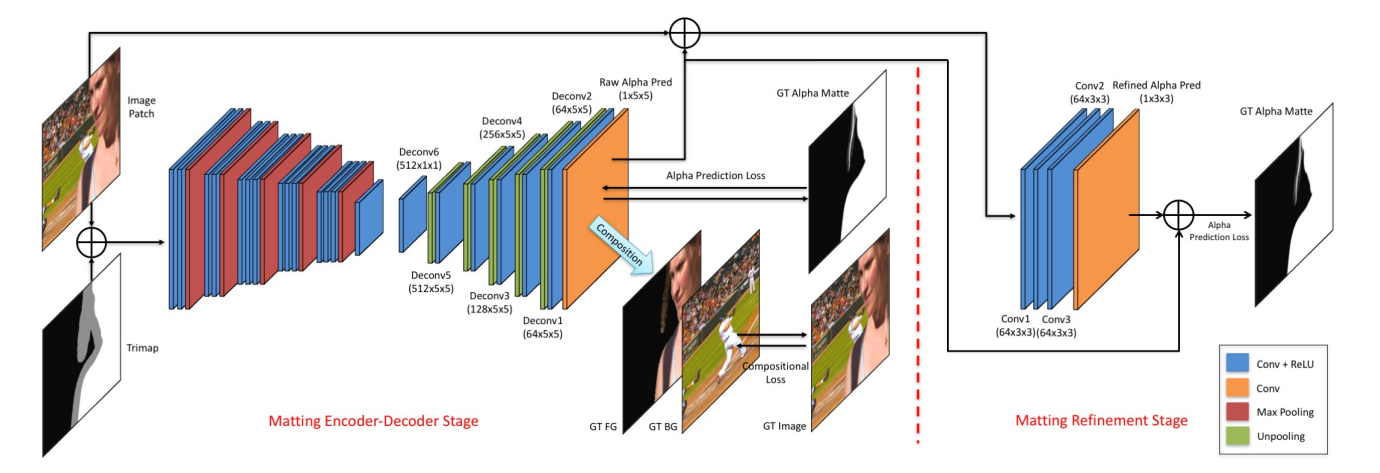

# Realize of Mnet


The second half network consists of an encoder network and a decoder network. The input to the encoder network is transformed into a downsampled feature map by subsequent convolutional layers and max-pooling layers. The input data is compressed to transform the complex input data into a simpler and more tractable representation. This process usually reduces the dimensionality of the data while preserving the main characteristics of the original data.

The decoder network in turn uses subsequent transpose layers which reverse the max pooling operation and transposed convolution layers to upsample the feature maps and have the desired output, the alpha matte in our case.

In [ ]:
class M_net(nn.Module):
    '''
        encoder + decoder
    '''

    def __init__(self, classes=2):

        super(M_net, self).__init__()
        # -----------------------------------------------------------------
        # encoder
        # ---------------------
        # 1/2
        self.en_conv_bn_relu_1 = nn.Sequential(nn.Conv2d(6, 16, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU())
        self.max_pooling_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 1/4
        self.en_conv_bn_relu_2 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.max_pooling_2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 1/8
        self.en_conv_bn_relu_3 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.max_pooling_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 1/16
        self.en_conv_bn_relu_4 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.max_pooling_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.en_conv_bn_relu_5 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        # -----------------------------------------------------------------
        # decoder
        # ---------------------
        # 1/8
        self.de_conv_bn_relu_1 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.deconv_1 = nn.ConvTranspose2d(128, 128, 5, 2, 2, 1, bias=False)

        # 1/4
        self.de_conv_bn_relu_2 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.deconv_2 = nn.ConvTranspose2d(64, 64, 5, 2, 2, 1, bias=False)

        # 1/2
        self.de_conv_bn_relu_3 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.deconv_3 = nn.ConvTranspose2d(32, 32, 5, 2, 2, 1, bias=False)

        # 1/1
        self.de_conv_bn_relu_4 = nn.Sequential(nn.Conv2d(32, 16, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU())
        self.deconv_4 = nn.ConvTranspose2d(16, 16, 5, 2, 2, 1, bias=False)


        self.conv = nn.Conv2d(16, 1, 5, 1, 2, bias=False)


    def forward(self, input):

        # ----------------
        # encoder
        # --------
        x = self.en_conv_bn_relu_1(input)
        x = self.max_pooling_1(x)

        x = self.en_conv_bn_relu_2(x)
        x = self.max_pooling_2(x)

        x = self.en_conv_bn_relu_3(x)
        x = self.max_pooling_3(x)

        x = self.en_conv_bn_relu_4(x)
        x = self.max_pooling_4(x)
        # ----------------
        # decoder
        # --------
        x = self.de_conv_bn_relu_1(x)
        x = self.deconv_1(x)
        x = self.de_conv_bn_relu_2(x)
        x = self.deconv_2(x)

        x = self.de_conv_bn_relu_3(x)
        x = self.deconv_3(x)

        x = self.de_conv_bn_relu_4(x)
        x = self.deconv_4(x)

        # raw alpha pred
        out = self.conv(x)

        return out

# Matting Network

This part is the overall implementation of our matting network.  As we can see from the network structure below:

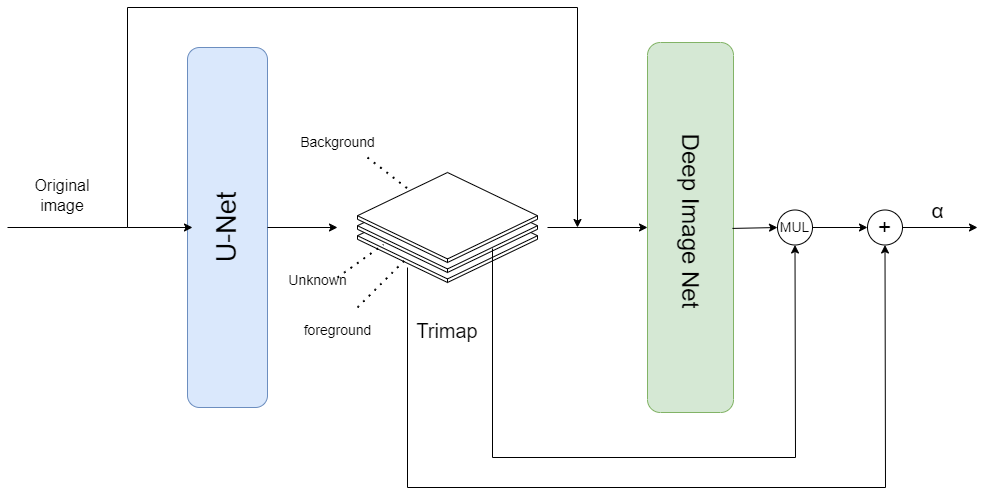


By combining mv2_net and unet, a new architecture is built to obtain the trimap. After converting the trimap to a probability distribution using softmax, we can split the image into three parts: the background, the uncertain part, and the foreground (probability). At this point, we have reached the two inputs required by the matting network, the original image and the probability distribution transformed by the trimap, and we can get the preliminary raw picture by putting them into execution. Finally, by adding the previously obtained foreground to the part of the unknown region that has a high probability of belonging to the foreground, we can obtain a good portrait matting.

In [ ]:
class Matting_net(nn.Module):


    def __init__(self):

        super(Matting_net, self).__init__()

        self.u_net = mv2_unet(3)
        self.m_net = M_net()
        #self.m_net=M_net_avrage_pool()


    def forward(self, input):

    	# trimap
        trimap = self.u_net(input)
        #trimap=F.interpolate(trimap, scale_factor=2, mode='bilinear', align_corners=False)
        trimap_softmax = F.softmax(trimap, dim=1)

        # paper: bs, fs, us
        bg, unsure, fg = torch.split(trimap_softmax, 1, dim=1)

        # concat input and trimap
        m_net_input = torch.cat((input, trimap_softmax), 1)

        # matting
        alpha_r = self.m_net(m_net_input)
        # fusion module
        # paper : alpha_p = fs + us * alpha_r
        alpha_p = fg + unsure * alpha_r

        return trimap, alpha_p

In [ ]:
net=Matting_net()
summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

# Loss For Matting Network


The overall network is divided into two trainings: pretrain-unet and end-to-end training. In order to calculate the loss curve and see how well the model works, we will divide the loss into three types and two overall parts.

For Unet traning phase we still use Cross Entropy as our loss function.

Then, M-net calculates the loss value loss_p. M-net calculates two different losses.

The first loss is called the alpha-prediction loss,  which is the absolute difference between the ground truth alpha values and the predicted alpha values at each pixel.


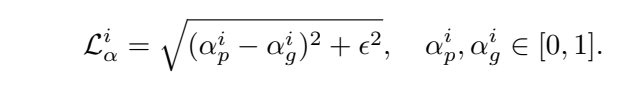

The second loss is called the compositional loss, which is the absolute difference between the ground truth RGB colors and the predicted RGB colors composited by the ground truth foreground, the ground truth background and the predicted alpha mattes.

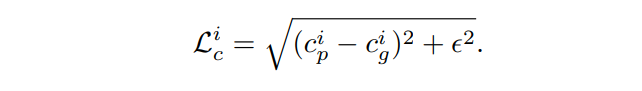

'eps' is a small constant to ensure numerical stability in subsequent computations.

Then the overall loss function of M_net(loss_p) is the weighted summation of the two individual losses, where weight is set to 0.5 in our experiment.

It is worth mentioning that when calculating the end-to-end loss, we multiply l_t by 0.02 as a constraint to calculate the overall value

In [ ]:
def loss_function_for_Matting_Network(args, img, trimap_pre, trimap_gt, alpha_pre, alpha_gt):

    # -------------------------------------
    # classification loss L_t
    # ------------------------
    # Cross Entropy
    # criterion = nn.BCELoss()
    # trimap_pre = trimap_pre.contiguous().view(-1)
    # trimap_gt = trimap_gt.view(-1)
    # L_t = criterion(trimap_pre, trimap_gt)

    criterion = nn.CrossEntropyLoss()
    L_t = criterion(trimap_pre, trimap_gt[:,0,:,:].long())
    # trimap_pre=torch.log_softmax(trimap_pre,dim=1)
    # L_t= F.nll_loss(trimap_pre, trimap_gt[:,0,:,:].long())

    # -------------------------------------
    # prediction loss L_p
    # ------------------------
    eps = 1e-6
    # l_alpha
    L_alpha = torch.sqrt(torch.pow(alpha_pre - alpha_gt, 2.) + eps).mean()

    # L_composition
    fg = torch.cat((alpha_gt, alpha_gt, alpha_gt), 1) * img
    fg_pre = torch.cat((alpha_pre, alpha_pre, alpha_pre), 1) * img

    L_composition = torch.sqrt(torch.pow(fg - fg_pre, 2.) + eps).mean()

    L_p = 0.5*L_alpha + 0.5*L_composition

    # train_phase
    if args.train_phase == 'pre_train':
        loss = L_t
    if args.train_phase == 'end_to_end':
        loss = L_p + 0.02*L_t

    return loss, L_alpha, L_composition, L_t

# Data Augmentation

Similarly, to enhance the performance of our deep learning models, we use data enhancement techniques, mainly morphological erosion and inflation operations. They are common image processing operations that change the shape and structure of pixels in an image. They can change the shape, size, and boundaries of a target, thus expanding the training dataset and increasing the model's ability to adapt to different morphological targets.

Here we apply morphological erosion and dilation operations to generate the trimap (used to indicate the boundary region between foreground and background). We define the function erode_dilate to normalise the input binary image, perform the erosion and dilation operations separately, and finally return the trimmed image res, which contains the background, foreground, and indeterminate regions.

Afterwards, we output the trimmed image trimap through the generate_trimap function.

In [ ]:
def erode_dilate(msk, struc="ELLIPSE", size=(10, 10)):
    if struc == "RECT":
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, size)
    elif struc == "CORSS":
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, size)
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, size)

    msk = msk / 255


    dilated = cv2.dilate(msk, kernel, iterations=1) * 255
    eroded = cv2.erode(msk, kernel, iterations=1) * 255


    res = dilated.copy()
    #res[((dilated == 255) & (msk == 0))] = 128
    res[((dilated == 255) & (eroded == 0))] = 128

    return res

In [ ]:
def generate_trimap():
  mskDir='/content/drive/MyDrive/Colab Notebooks/P3M-10k/train/mask'
  saveDir="./var_traimap"
  train_list="/content/drive/MyDrive/P3M_var.txt"
  kernel_size=10
  f = open(train_list)
  names = f.readlines()
  print("Images Count: {}".format(len(names)))
  for name in tqdm(names, total=len(names)):
    msk_name = mskDir +"/"+ name[:-1]+'.png'


    trimap_name =saveDir + "/"+ name[:-1]+'.png'
    trimap_name_1 = trimap_name.split("/")[:-1]

    trimap_path = "/".join(trimap_name_1)
    if not os.path.exists(trimap_path):
        os.makedirs(trimap_path)
    msk = cv2.imread(filename=msk_name,flags=0)

    trimap = erode_dilate(msk, size=(kernel_size,kernel_size))



    cv2.imwrite(trimap_name, trimap)
  print('')
  print("Succesfully generated!")
generate_trimap()

Images Count: 100


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Succesfully generated!


The trimap section we generated is shown below:

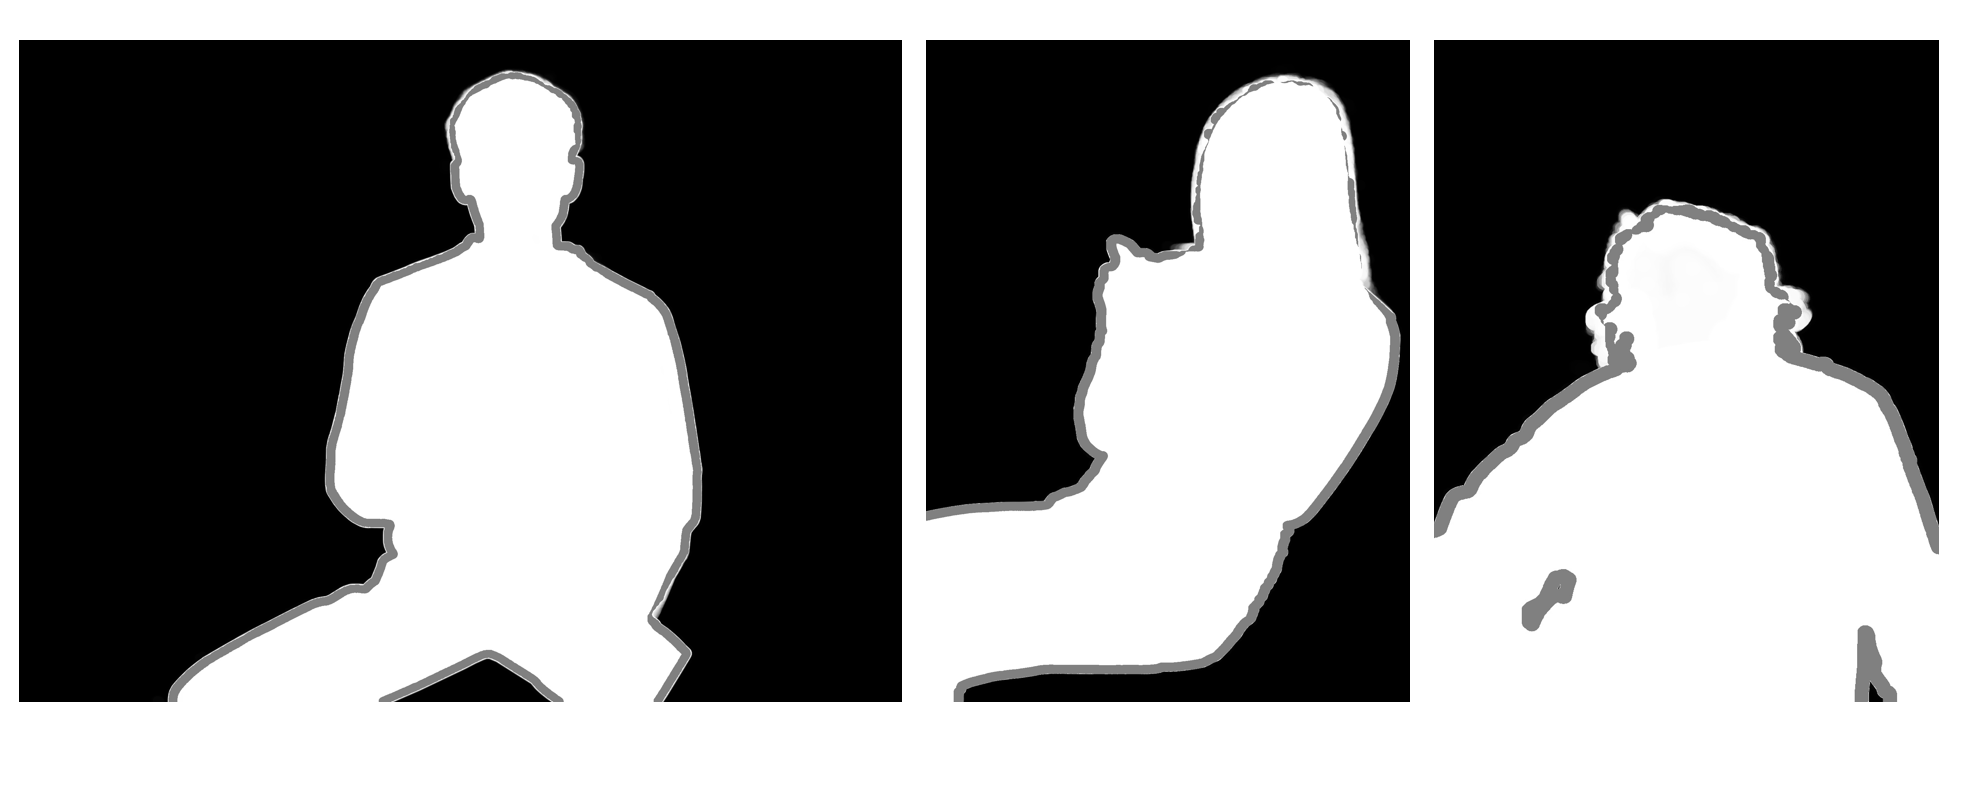

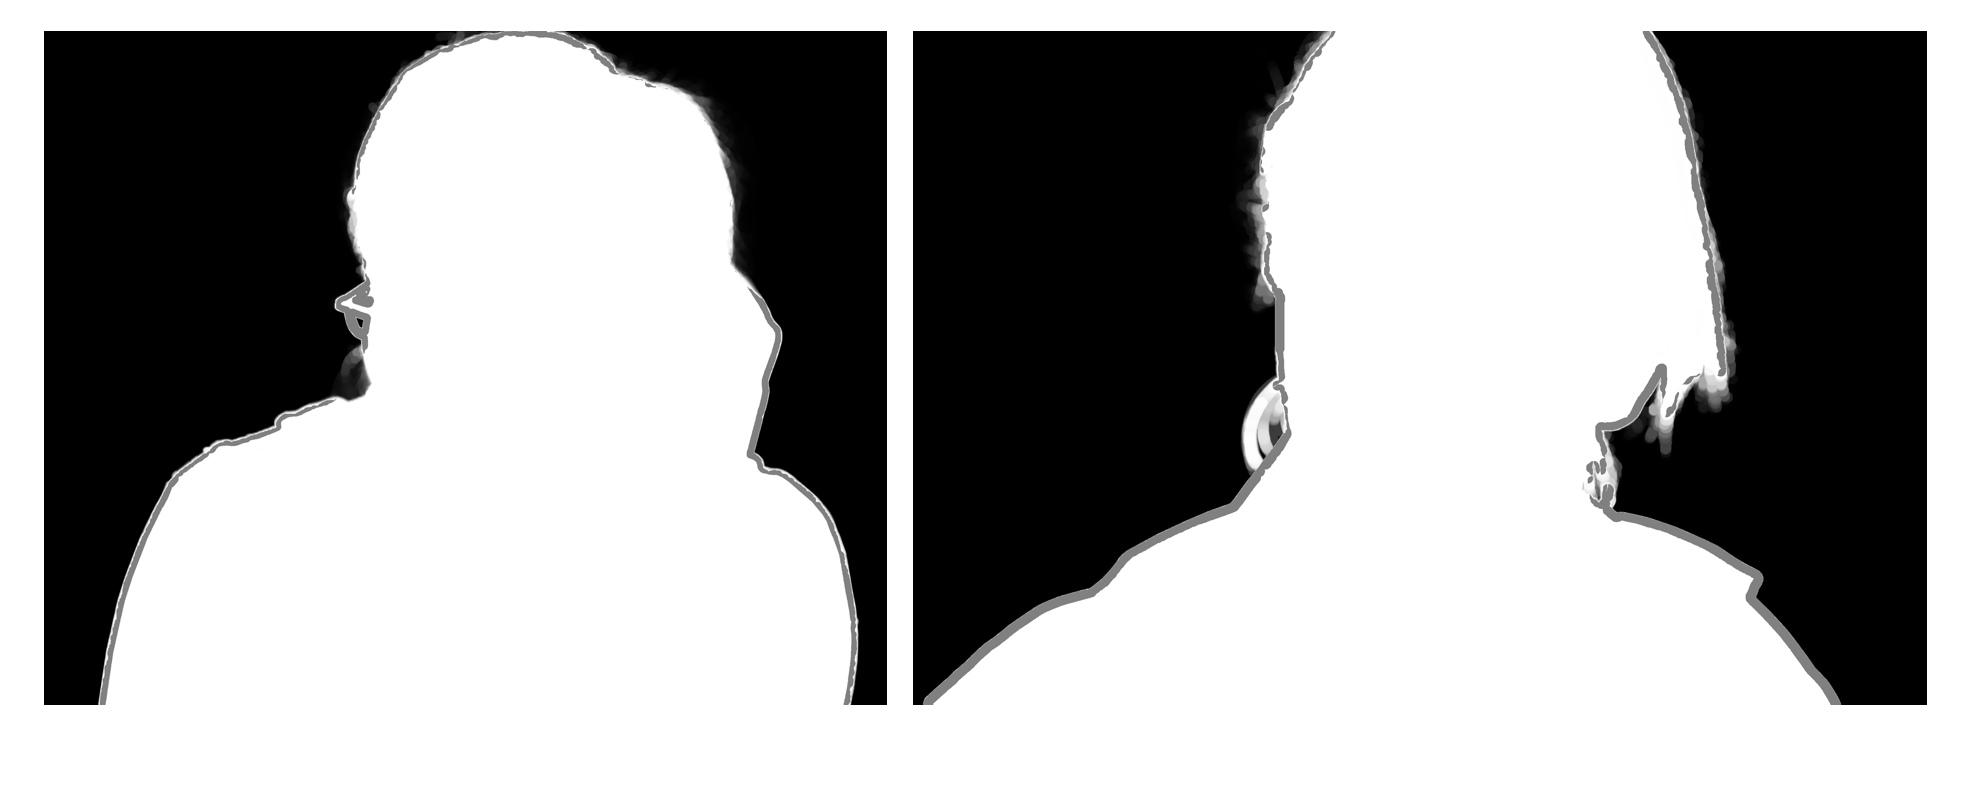

Next we defined the class P3MforMatting to read the dataset for easy training, which loads the images, trim maps (trimap) and true labels (alpha) from the human segmentation task and augments and preprocesses them with data, as shown in the code below:

In [ ]:
from torchvision import transforms
class P3MforMatting(data.Dataset):
    """
    human_matting
    """

    def __init__(self, root_dir, imglist, patch_size):
        super().__init__()
        self.data_root = root_dir

        self.patch_size = patch_size
        with open(imglist) as f:
            self.imgID = f.readlines()
        self.num = len(self.imgID)
        print("Dataset : file number %d"% self.num)
    def random_scale_and_creat_patch(self,image, trimap, alpha, patch_size):
        if r.random() < 0.5:
          h, w, c = image.shape
          scale = 0.75 + 0.5*r.random()
          image = cv2.resize(image, (int(w*scale),int(h*scale)), interpolation=cv2.INTER_CUBIC)
          trimap = cv2.resize(trimap, (int(w*scale),int(h*scale)), interpolation=cv2.INTER_NEAREST)
          alpha = cv2.resize(alpha, (int(w*scale),int(h*scale)), interpolation=cv2.INTER_CUBIC)
        # creat patch
        # if r.random() < 0.5:
        #     h, w, c = image.shape
        #     if h > patch_size and w > patch_size:
        #         x = r.randrange(0, w - patch_size)
        #         y = r.randrange(0, h - patch_size)
        #         image = image[y:y + patch_size, x:x+patch_size, :]
        #         trimap = trimap[y:y + patch_size, x:x+patch_size, :]
        #         alpha = alpha[y:y+patch_size, x:x+patch_size, :]
        #     else:
        #         image = cv2.resize(image, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)
        #         trimap = cv2.resize(trimap, (patch_size,patch_size), interpolation=cv2.INTER_NEAREST)
        #         alpha = cv2.resize(alpha, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)
        # else:
        image = cv2.resize(image, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)
        trimap = cv2.resize(trimap, (patch_size,patch_size), interpolation=cv2.INTER_NEAREST)
        alpha = cv2.resize(alpha, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)

        return image, trimap, alpha
    def random_flip(self,image, trimap, alpha):

        if r.random() < 0.5:
            image = cv2.flip(image, 0)
            trimap = cv2.flip(trimap, 0)
            alpha = cv2.flip(alpha, 0)

        if r.random() < 0.5:
            image = cv2.flip(image, 1)
            trimap = cv2.flip(trimap, 1)
            alpha = cv2.flip(alpha, 1)
        return image, trimap, alpha
    def read_files(self, file_name={}):
        image_name = os.path.join("/content/drive/MyDrive/Colab Notebooks/P3M-10k/train/blurred_image", file_name['image'])
        trimap_name = os.path.join("/content/drive/MyDrive/Colab Notebooks/P3M-10_trimap/trimap", file_name['trimap'])
        alpha_name = os.path.join("/content/drive/MyDrive/Colab Notebooks/P3M-10k/train/mask", file_name['alpha'])  # '

        image = cv2.imread(image_name)
        trimap = cv2.imread(trimap_name)
        alpha = cv2.imread(alpha_name)

        return image, trimap, alpha

    def __getitem__(self, index):
        # read files
        image, trimap, alpha = self.read_files(
                            file_name={'image': self.imgID[index].strip()+'.jpg',
                                        'trimap': self.imgID[index].strip() +'.png',
                                        'alpha': self.imgID[index].strip() +'.png'})
        # NOTE ! ! !
        # trimap should be 3 classes : fg, bg. unsure
        trimap[trimap == 0] = 0
        trimap[trimap >= 250] = 2
        trimap[np.where(~((trimap == 0) | (trimap == 2)))] = 1

        # augmentation
        image, trimap, alpha = self.random_scale_and_creat_patch(image, trimap, alpha, self.patch_size)
        image, trimap, alpha = self.random_flip(image, trimap, alpha)

        # normalize
        # image = (image.astype(np.float32)  - (114., 121., 134.,)) / 255.0
        alpha = alpha.astype(np.float32) / 255.0
        # to tensor
        image = np2Tensor(image)
        trimap = np2Tensor(trimap)
        alpha = np2Tensor(alpha)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        image = normalize(image / 255)
        trimap = trimap[0, :, :].unsqueeze_(0)
        alpha = alpha[0, :, :].unsqueeze_(0)

        sample = {'image': image, 'trimap': trimap, 'alpha': alpha}

        return sample

    def __len__(self):
        return self.num

# Training

Training: Freeze and unfreeze

Because the features extracted by the feature extraction part of the backbone of the neural network are general, we freeze some parts of the training network to speed up the training efficiency and also prevent the weight from being destroyed.

During the training phase we did the following(40 epochs):

1) 0: freeze backbone

2) 20: unfreeze backbone

3) 25: freeze U_net

4) 35: unfreeze U_net

Because we are using data that have already been pre-trained, so we can freeze the mobilenet_v2 at Epoch=0. Focusing on training the decoder part of U_net and continue the work of feature extraction; at epoch=20, the Mobile_net is unfrozen, and the mobilev2_Unet_model is trained as a whole; At epoch=25, the first phase of training is over, we have got the generated trimap at this time. Next let’s start the second phase: Mnet training.


In [ ]:
class Matting_train_args():
  def __init__(self,saveDir='./ckpt',trainList='/content/drive/MyDrive/Colab Notebooks/P3M_demo.txt',) :
       self.dataDir='/content/drive/MyDrive/Colab Notebooks/P3M-10k/train'
       self.saveDir=saveDir
       self.trainList=trainList
       self.vaList='/content/drive/MyDrive/P3M_var.txt'
       self.load='human_matting'
       self.finetuning=False
       self.without_gpu=True
       self.nThreads=0
       self.train_batch=2
       self.patch_size=256
       self.freeze_epoch=20
       self.change_train_phase=25
       self.unfreeze_tnet_epoch=35
       self.lr=1e-4
       self.lrDecay=15
       self.lrdecayType = 'step' #'keep' or 'step'
       self.nEpochs=40
       self.save_epoch=1
       self.gpus='0'
       self.train_phase='pre_train'

In [ ]:
def matting_train(model):

  print("=============> Loading args")
  args=Matting_train_args()

  print("============> Environment init")
  if args.without_gpu:
      print("use CPU !")
      device = torch.device('cpu')
  else:
      if torch.cuda.is_available():
          device = torch.device('cuda')
      else:
          print("No GPU is is available !")

  print("============> Building model ...")

  model.to(device)

  print("============> Loading datasets ...")
  train_data = P3MforMatting(root_dir = args.dataDir, \
                                                imglist = args.trainList, \
                                                patch_size = args.patch_size)
  trainloader = DataLoader(train_data,
                            batch_size=args.train_batch,
                            drop_last=True,
                            shuffle=True,
                            num_workers=args.nThreads,
                            pin_memory=True)

  validation_data=P3MforMatting(root_dir = args.dataDir, \
                                                imglist = args.vaList, \
                                                patch_size = args.patch_size)
  valoader=DataLoader(validation_data,
                            batch_size=args.train_batch,
                            drop_last=True,
                            shuffle=True,
                            num_workers=args.nThreads,
                            pin_memory=True)

  print("============> Set optimizer ...")
  lr = args.lr
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), \
                                  lr=lr, betas=(0.9, 0.999),
                                  weight_decay=0.0005)

  print("============> Start Train ! ...")
  start_epoch = 1
  trainlog = Train_Log(args)
  # if args.train_phase == 'end_to_end':
  #
  #    losses={'total_loss':[],'composition_loss':[],'L_t_loss':[],'matte_loss':[]}
  # else:
  #    losses={'L_t_loss':[]}
  if args.finetuning:
      start_epoch, model = trainlog.load_model(model)
      start_epoch+=1

  model.train()
  total_step = len(trainloader)
  if args.freeze_epoch > start_epoch:
      print("============> Freeze Backbone ...")
      model.t_net.freeze_backbone()
      args.train_phase='pre_train'
  elif start_epoch< args.change_train_phase:
      args.train_phase = 'pre_train'
  elif start_epoch<args.unfreeze_tnet_epoch:
      print("============> Freeze Tnet ...")
      args.train_phase='end_to_end'
      model.t_net.freeze()
  else:
      args.train_phase = 'end_to_end'
  for epoch in range(start_epoch, args.nEpochs+1):
      if epoch==args.freeze_epoch:
          print("============> Unfreeze Backbone ...")
          model.t_net.unfreeze_backbone()
      if epoch==args.change_train_phase:
          print("============> Traning Phase Changed, Freeze Tnet ...")
          model.t_net.freeze()
          args.train_phase='end_to_end'
      if epoch==args.unfreeze_tnet_epoch:
          print("============> Unfreeze Tnet...")
          model.t_net.unfreeze()

      loss_ = 0
      L_alpha_ = 0
      L_composition_ = 0
      L_cross_ = 0
      vloss_ = 0
      vL_alpha_ = 0
      vL_composition_ = 0
      vL_cross_ = 0
      if args.lrdecayType != 'keep':
          lr = set_lr(args, epoch, optimizer)

      t0 = time.time()



      pbar = enumerate(trainloader)
      pbar = tqdm(pbar, total=total_step)
      model.train()
      for i, sample_batched in pbar:
          img, trimap_gt, alpha_gt = sample_batched['image'], sample_batched['trimap'], sample_batched['alpha']
          img, trimap_gt, alpha_gt = img.to(device), trimap_gt.to(device), alpha_gt.to(device)

          trimap_pre, alpha_pre = model(img)
          loss, L_alpha, L_composition, L_cross = loss_function_for_Matting_Network(args,
                                        img,
                                        trimap_pre,
                                        trimap_gt,
                                        alpha_pre,
                                                                alpha_gt)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          loss_ += loss.item()
          L_alpha_ += L_alpha.item()
          L_composition_ += L_composition.item()
          L_cross_ += L_cross.item()

      print("============> Validation...")
      pbar = enumerate(valoader)
      vtotal_step = len(valoader)
      pbar = tqdm(pbar, total=vtotal_step)
      model.eval()

      for j, sample_batched in pbar:
          img, trimap_gt, alpha_gt = sample_batched['image'], sample_batched['trimap'], sample_batched['alpha']
          img, trimap_gt, alpha_gt = img.to(device), trimap_gt.to(device), alpha_gt.to(device)

          trimap_pre, alpha_pre = model(img)
          loss, L_alpha, L_composition, L_cross = loss_function_for_Matting_Network(args,
                                                    img,
                                                    trimap_pre,
                                                    trimap_gt,
                                                    alpha_pre,
                                                    alpha_gt)

          vloss_ += loss.item()
          vL_alpha_ += L_alpha.item()
          vL_composition_ += L_composition.item()
          vL_cross_ += L_cross.item()
      if epoch % args.save_epoch == 0:

          # speed = (t1 - t0) / 60
          # if args.train_phase == 'end_to_end':
          #     losses['total_loss'].append(loss_/ (i+1))
          #     losses['composition_loss'].append(L_composition_/ (i+1))
          #     losses['L_t_loss'].append(L_cross_/ (i+1))
          #     losses['matte_loss'].append(L_alpha_/ (i+1))
          #     trainlog.show_losses(losses, epoch//args.save_epoch)
          # else:
          #     losses['L_t_loss'].append(loss_/ (i+1))
          #     trainlog.show_losses_tnet(losses,epoch//args.save_epoch)

          loss_ = loss_ / (i+1)
          L_alpha_ = L_alpha_ / (i+1)
          L_composition_ = L_composition_ / (i+1)
          L_cross_ = L_cross_ / (i+1)
          vloss_ = vloss_ / (j + 1)
          vL_alpha_ = vL_alpha_ / (i + 1)
          vL_composition_ = vL_composition_ / (j + 1)
          vL_cross_ = vL_cross_ / (j + 1)

          log = "[{} / {}] \tLr: {:.5f}\n Training loss: {:.5f}\tloss_p: {:.5f}\tloss_t: {:.5f}\n" \
                "Validation loss: {:.5f}\tloss_p: {:.5f}\tloss_t: {:.5f}\t" \
                    .format(epoch, args.nEpochs,
                          lr,
                          loss_,
                          L_alpha_+L_composition_,
                          L_cross_,
                            vloss_,
                            vL_alpha_+vL_composition_,
                            vL_cross_

                            )
          print(log)
          trainlog.save_log(log)
          trainlog.save_model(model, epoch)

In [ ]:
torch.set_grad_enabled(True)
model = Matting_net()
matting_train(model)

=============> Loading args
============> Environment init
use CPU !
============> Building model ...
============> Loading datasets ...
Dataset : file number 999
Dataset : file number 100
============> Set optimizer ...
============> Start Train ! ...
============> Freeze Backbone ...


  0%|          | 0/499 [01:43<?, ?it/s]


KeyboardInterrupt: ignored

# Test&Result

After applying the model training with deep keying network and data augmentation operations, we calculated the average validation loss for the training and validation sets as follows:

In [ ]:
class Matting_net_Test_args():
  def __init__(self):
    self.model='/content/drive/MyDrive/ckpt_shm/back_up/without_avg/ckpt_lastest_pretrain_Unet_maxpool_freeze_backbone &Tnet_40epoch.pth'
    self.loss_result='/content/drive/MyDrive/ckpt_shm/back_up/without_avg/Losses_over_epoches_pretrain_Unet_maxpool_freeze_backbone &Tnet_40epoch.png'
    self.size=256
    self.without_gpu=True
    self.pic_path='/content/drive/MyDrive/gg.jpg'
    self.test_pic_path='/content/drive/MyDrive/test.txt'
    self.net=Matting_net()
args=Matting_net_Test_args()

With this figure, we can see that due to the change in the training phase, the loss equation has changed, resulting in a sudden drop in loss in the middle. The first half is still the cross entropy of U-Net, while the second half adopts the Deep Image Matting network structure, which consists of two parts: the Matting encoder-decoder stage and the Matting refinement stage. The Matting encoder-decoder stage, i.e., the deep convolutional encoding-decoding network, which uses the image's encoding and decoding algorithms, is the first half. decoder stage, which is the deep convolutional encoding and decoding network, uses the three-channel tensor of the image and trimap stack as input, and the loss function consists of the α-prediction loss and the new component loss; the Matting refinement stage, which is the small fully convolutional network, refines the α-prediction of the output of the first stage and obtains finer α-values and more accurate foreground edges. accurate foreground edges.

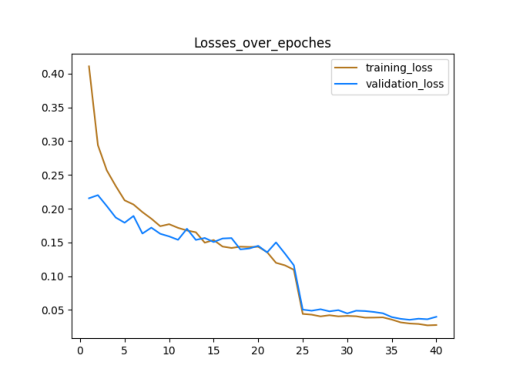

In [ ]:
show_losses()

In [ ]:
if args.without_gpu:
    print("use CPU !")
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        n_gpu = torch.cuda.device_count()
        print("----------------------------------------------------------")
        print("|       use GPU !      ||   Available GPU number is {} !  |".format(n_gpu))
        print("----------------------------------------------------------")

        device = torch.device('cuda:0,1')

use CPU !


We continue to use the function load_model and the function unet_test_one_pic to display the resultant image, respectively:

1. original image
2. pruned image applying U-Net network model
3. the resultant image applying the M-Net keying network
4. original image multiplied with the keying result to get the final foreground result image

In [ ]:
def normalize(image, mean, std):
    image = image.astype(np.float32) / 255.0  # Converts an image to a floating point number between 0 and 1
    image = (image - mean) / std  # normalization image

Loading model from /content/drive/MyDrive/ckpt_shm/back_up/without_avg/ckpt_lastest_pretrain_Unet_maxpool_freeze_backbone &Tnet_40epoch.pth...


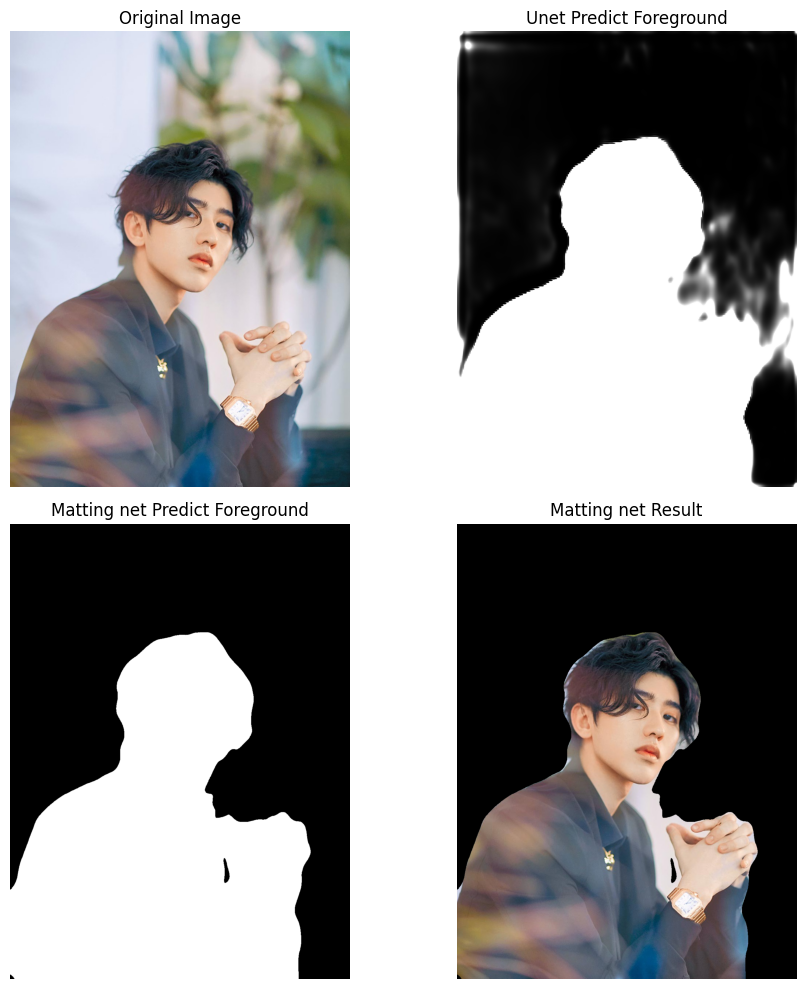

In [ ]:
def test_one_pic():
  torch.set_grad_enabled(False)
  net=load_model(args)
  image=cv2.imread(args.pic_path)
  origin_h, origin_w, c = image.shape
  image_resize1 = cv2.resize(image, (args.size, args.size), interpolation=cv2.INTER_CUBIC)
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image_resize = normalize(image_resize1, mean, std)
  tensor_4D = torch.FloatTensor(1, 3, args.size, args.size)

  tensor_4D[0, :, :, :] = torch.FloatTensor(image_resize.transpose(2, 0, 1))
  inputs = tensor_4D.to(device)
  trimap, alpha = net(inputs)
  trimap = F.softmax(trimap, dim=1)
  trimap_np = trimap[0, 2, :, :].cpu().data.numpy()

  # pr = cv2.resize(np.uint8(pr), (origin_w, origin_h), interpolation=cv2.INTER_CUBIC)
  # #pr = cv2.cvtColor(np.asarray(imag), cv2.COLOR_RGB2BGR)
  # mask_result = np.multiply(pr[..., np.newaxis], image)
  trimap_np = cv2.resize(trimap_np, (origin_w, origin_h), interpolation=cv2.INTER_CUBIC)
  trimap_1 = trimap_np.copy()*255
  image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
  trimap_1=cv2.cvtColor(trimap_1,cv2.COLOR_RGB2BGR)
  if args.without_gpu:
      alpha_np = alpha[0, 0, :, :].data.numpy()
  else:
      alpha_np = alpha[0, 0, :, :].cpu().data.numpy()
  alpha_np = cv2.resize(alpha_np, (origin_w, origin_h), interpolation=cv2.INTER_CUBIC)


  alpha_np_1 = alpha_np.copy() * 255
  alpha_np[alpha_np_1 < 128] = 0
  alpha_np[alpha_np_1 >= 128] = 1
  final_mask=alpha_np*255
  final_mask=cv2.cvtColor(final_mask,cv2.COLOR_RGB2BGR)
  alpha_np=np.expand_dims(alpha_np, axis=2)
  fg = np.where(alpha_np == 1, image, 0)
  # fg[fg<=0] = 255
  # fg[fg>255] = 0
  fg = fg.astype(np.uint8)
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))
  axs[0][0].imshow(image)
  axs[0][0].axis('off')
  axs[0][0].set_title('Original Image')
  axs[0][1].imshow(trimap_1)
  axs[0][1].axis('off')
  axs[0][1].set_title('Unet Predict Foreground')
  axs[1][0].imshow(final_mask)
  axs[1][0].set_title('Matting net Predict Foreground')
  axs[1][0].axis('off')
  axs[1][1].imshow(fg)
  axs[1][1].set_title('Matting net Result')
  axs[1][1].axis('off')
  plt.tight_layout()

  plt.show()
test_one_pic()

Next we compute mIoU and accuracy, unlike the previous computation we invoke threshold for because the keying network output is a one-dimensional representation of the probability of a person, we need to convert the predicted probability to a binary predictive label. The specific code is shown below:


In [ ]:
def calculate_mIoU_with_threshold(pred_probs, true_labels, threshold=0.5):
    pred_labels = (pred_probs >= threshold).astype(int)
    iou = calculate_iou(pred_labels, true_labels)
    return iou

def calculate_accuracy_with_threshold(pred_probs, true_labels, threshold=0.5):
    pred_labels = (pred_probs >= threshold).astype(int)
    accuracy = np.sum(pred_labels == true_labels) / pred_labels.size
    return accuracy

In [ ]:
def Matting_get_predictions(net,image):
    origin_h, origin_w, c = image.shape
    image_resize = cv2.resize(image, (args.size, args.size), interpolation=cv2.INTER_CUBIC)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_resize = normalize(image_resize, mean, std)

    tensor_4D = torch.FloatTensor(1, 3, args.size, args.size)

    tensor_4D[0, :, :, :] = torch.FloatTensor(image_resize.transpose(2, 0, 1))
    inputs = tensor_4D.to(device)

    trimap, alpha = net(inputs)

    # print(trimap)
    if args.without_gpu:
        alpha_np = alpha[0, 0, :, :].data.numpy()
    else:
        alpha_np = alpha[0, 0, :, :].cpu().data.numpy()

    pr=cv2.resize(alpha_np,(origin_w,origin_h),interpolation=cv2.INTER_NEAREST)
    return pr

In [ ]:
def test_Matting_net_miou():
    myModel = load_model(args)
    with open(args.test_pic_path) as f:
        imgID = f.readlines()
    num = len(imgID)
    total_imou=0
    accuracy=0
    print("Dataset : file number %d" % num)
    par=enumerate(imgID)
    par=tqdm(par,total=num)
    for i,img in par:
        image_name = os.path.join("/content/drive/MyDrive/Colab Notebooks/P3M-10k/train","blurred_image", img[:-1]+'.jpg')
        alpha_name = os.path.join('/content/drive/MyDrive/Colab Notebooks/P3M-10k/train',"mask",img[:-1]+'.png')
        #print(alpha_name)
        alpha = cv2.imread(alpha_name,cv2.IMREAD_GRAYSCALE)
        #alpha=  cv2.resize(alpha, (input_size, input_size), interpolation=cv2.INTER_CUBIC)
        alpha=alpha/255
        image = cv2.imread(image_name)
        alpha_pred=Matting_get_predictions(myModel,image)
        total_imou += calculate_mIoU_with_threshold(alpha_pred, alpha)
        accuracy += calculate_accuracy_with_threshold(alpha_pred, alpha)
    print("mIoU:", total_imou/num)
    print("Accuracy:", accuracy/num)
test_Matting_net_miou()

Loading model from /content/drive/MyDrive/ckpt_shm/back_up/without_avg/ckpt_lastest_pretrain_Unet_maxpool_freeze_backbone &Tnet_40epoch.pth...
Dataset : file number 100


100%|██████████| 100/100 [03:32<00:00,  2.12s/it]

mIoU: 0.9280144149231551
Accuracy: 0.9612564251029181


After testing, we got the final result based on M-Net model training:

Test2

mIoU: 0.9280144149231551

Accuracy: 0.9612564251029181

# avg_pool Mnet


In order to improve the mIoU and accuracy of the keying effect, we try to replace max_pool with average_pool in the M-Net keying network, the specific code modification is as follows:

In [ ]:
class M_net_avrage_pool(nn.Module):

    def __init__(self, classes=2):

        super(M_net_avrage_pool, self).__init__()
        # -----------------------------------------------------------------
        # encoder
        # ---------------------
        # 1/2
        self.en_conv_bn_relu_1 = nn.Sequential(nn.Conv2d(6, 16, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU())
        self.avg_pooling_1 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

        # 1/4
        self.en_conv_bn_relu_2 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.avg_pooling_2 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

        # 1/8
        self.en_conv_bn_relu_3 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.avg_pooling_3 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

        # 1/16
        self.en_conv_bn_relu_4 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.avg_pooling_4 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

        self.en_conv_bn_relu_5 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        # -----------------------------------------------------------------
        # decoder
        # ---------------------
        # 1/8
        self.de_conv_bn_relu_1 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.deconv_1 = nn.ConvTranspose2d(128, 128, 5, 2, 2, 1, bias=False)

        # 1/4
        self.de_conv_bn_relu_2 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.deconv_2 = nn.ConvTranspose2d(64, 64, 5, 2, 2, 1, bias=False)

        # 1/2
        self.de_conv_bn_relu_3 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.deconv_3 = nn.ConvTranspose2d(32, 32, 5, 2, 2, 1, bias=False)

        # 1/1
        self.de_conv_bn_relu_4 = nn.Sequential(nn.Conv2d(32, 16, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU())
        self.deconv_4 = nn.ConvTranspose2d(16, 16, 5, 2, 2, 1, bias=False)


        self.conv = nn.Conv2d(16, 1, 5, 1, 2, bias=False)


    def forward(self, input):

        # ----------------
        # encoder
        # --------
        x = self.en_conv_bn_relu_1(input)
        x = self.avg_pooling_1(x)

        x = self.en_conv_bn_relu_2(x)
        x = self.avg_pooling_2(x)

        x = self.en_conv_bn_relu_3(x)
        x = self.avg_pooling_3(x)

        x = self.en_conv_bn_relu_4(x)
        x = self.avg_pooling_4(x)
        # ----------------
        # decoder
        # --------
        x = self.de_conv_bn_relu_1(x)
        x = self.deconv_1(x)
        x = self.de_conv_bn_relu_2(x)
        x = self.deconv_2(x)

        x = self.de_conv_bn_relu_3(x)
        x = self.deconv_3(x)

        x = self.de_conv_bn_relu_4(x)
        x = self.deconv_4(x)

        # raw alpha pred
        out = self.conv(x)

        return out

In [ ]:
class Matting_net_avgpoolM(nn.Module):

    def __init__(self):

        super(Matting_net_avgpoolM, self).__init__()

        self.t_net = mv2_unet()
        #self.m_net = M_net()
        self.m_net=M_net_avrage_pool()



    def forward(self, input):

    	# trimap
        trimap = self.t_net(input)
        #trimap=F.interpolate(trimap, scale_factor=2, mode='bilinear', align_corners=False)
        trimap_softmax = F.softmax(trimap, dim=1)

        # paper: bs, fs, us
        bg, unsure, fg = torch.split(trimap_softmax, 1, dim=1)

        # concat input and trimap
        m_net_input = torch.cat((input, trimap_softmax), 1)

        # matting
        alpha_r = self.m_net(m_net_input)
        # fusion module
        # paper : alpha_p = fs + us * alpha_r
        alpha_p = fg + unsure * alpha_r

        return trimap, alpha_p

In [ ]:
torch.set_grad_enabled(True)
model=Matting_net_avgpoolM()
matting_train(model)

=============> Loading args
============> Environment init
use CPU !
============> Building model ...
============> Loading datasets ...
Dataset : file number 999
Dataset : file number 100
============> Set optimizer ...
============> Start Train ! ...
============> Freeze Backbone ...


  0%|          | 2/499 [00:05<22:34,  2.73s/it]


KeyboardInterrupt: ignored

# Test&Result

After partially modifying the M-Net network model, we calculated the average validation loss for the training and validation sets as follows:

In [ ]:
'''
class Matting_net_Test_args():
  def __init__(self):
    self.model='/content/drive/MyDrive/ckpt_shm/back_up/without_avg/ckpt_lastest_pretrain_Unet_maxpool_freeze_backbone &Tnet_40epoch.pth'
    self.loss_result='/content/drive/MyDrive/ckpt_shm/back_up/without_avg/Losses_over_epoches_pretrain_Unet_maxpool_freeze_backbone &Tnet_40epoch.png'
    self.size=256
    self.without_gpu=True
    self.pic_path='/content/drive/MyDrive/a.jpg'
    self.test_pic_path='/content/drive/MyDrive/test.txt'
    self.net=Matting_net()
'''
args=Matting_net_Test_args()
args.model='/content/drive/MyDrive/ckpt_shm/back_up/with_avg/ckpt_lastest.pth'
args.pic_path='/content/drive/MyDrive/gg.jpg'
args.loss_result='/content/drive/MyDrive/ckpt_shm/back_up/with_avg/Losses_over_epoches_with_avg.png'
args.net=Matting_net_avgpoolM()

With the figure below, we can clearly see that the application of average_pool does not have a significant impact on the loss of the two parts, which is almost identical to the image when max_pool is applied:

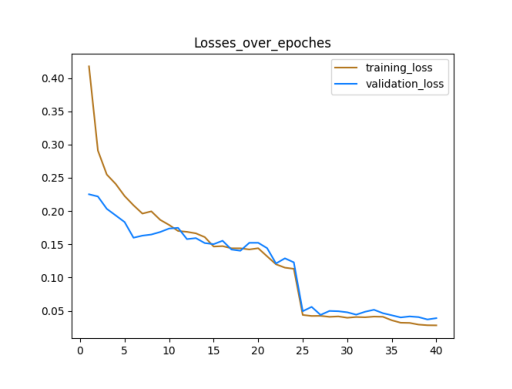

In [ ]:
show_losses()

The effect of applying the network to generate the four images is as follows:

Loading model from /content/drive/MyDrive/ckpt_shm/back_up/with_avg/ckpt_lastest.pth...


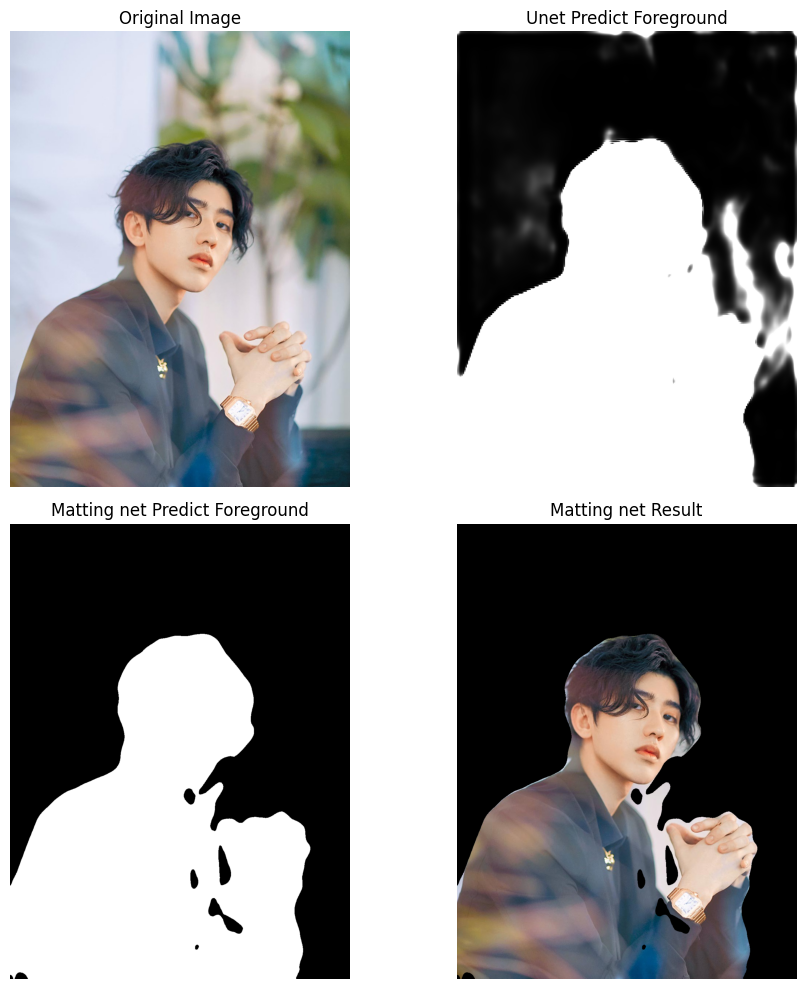

In [ ]:
test_one_pic()

In [ ]:
test_Matting_net_miou()

Loading model from /content/drive/MyDrive/ckpt_shm/back_up/with_avg/ckpt_lastest.pth...
Dataset : file number 100


100%|██████████| 100/100 [00:34<00:00,  2.92it/s]

mIoU: 0.924413328297771
Accuracy: 0.9621766449173446


After testing, we got the final results based on M-Net model training (avg_pool):

Test 3

mIoU: 0.924413328297771

Accuracy: 0.9621766449173446

In conclusion: Changing max_pool to avg_pool did not change the results significantly, but the application of max_pool is a little better, because Max Pooling retains salient features by selecting the maximum value in the feature map, which allows the network to better capture key features has a good perception of details such as edges, textures, etc. in the visual task.

# ASPP intro

Atrous Spatial Pyramid Pooling (ASPP) was first announced in the paper “Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs” in 2017, ASPP can robustly segment objects at multiple scales. ASPP probes an incoming convolutional feature layer with filters at multiple sampling rates and effective fields-of-views, thus capturing objects as well as image context at multiple scales.[1]
https://arxiv.org/abs/1606.00915v2

Many researches show that ASPP is robust and great on getting features, therefore we decide to implement it in our Unet nodule.


And here is the structure of ASPP:

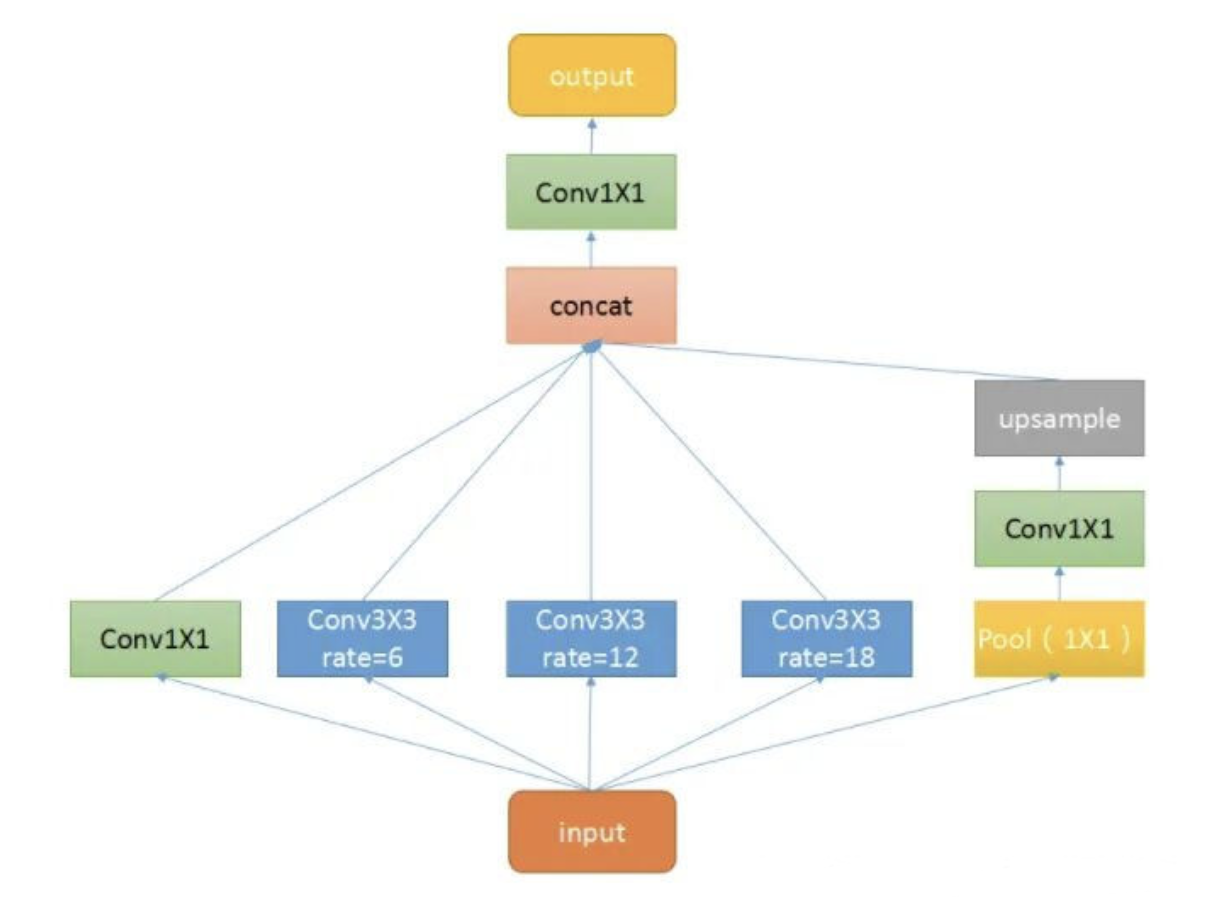

As we can see from the diagram of ASPP structure, ASPP is composed of a 1x1 convolution (most left green square), 3 pooling pyramids (middle 3 blue squares), and ASPP pooling (most right 3 layers), we can adjust the dilation rate and the atrous convolutional layers flexibly, that’s one of the advantages, ASPP also reduce the computational cost compared to other methods that rely on downsampling.



# Unet with ASPP


Untitled Diagram.drawio.svg

Incorporating the Atrous Spatial Pyramid Pooling (ASPP) into the U-Net architecture, as we can see from the diagram, we totally abandone the feature 5 process that was used before, besides, we modify the feature 4 process from Mobile Net V2 to Decoder of Unet to leverage the benefits of ASPP for capturing multi-scale contextual information. The ASPP module is introduced to enhance the feature extraction capabilities of the network. In feature 4 part, we have already downsampled multiple times, resulting in a loss of fine-grained spatial information. The ASPP module consists of parallel atrous convolutions with different dilation rates to capture contextual information at multiple scales, enabling the model to analyse the input image at different receptive field sizes and leading to improved segmentation results.

# Realisation of ASPP

This class defines a dilated convolutional block, followed by batch normalization and a ReLU activation.

 It is responsible for performing dilated convolutions with specified dilation rates to capture multi-scale information in the input feature map. It is important to note that the kernel size of the convolution remains fixed at 3x3.


In [ ]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


There is no need to specify the kernel size and stride; only the desired output size is specified (in this case, 1x1). By compressing each channel's feature map to a 1x1 size, it extracts features from each channel and obtains global features. Next is a 1x1 convolutional layer, which further extracts features and reduces dimensionality from the previously obtained features. It is essential to note that in the ASPP Pooling network architecture, feature extraction is performed; whereas in the forward method, besides sequentially executing the layers of the network, the final feature map is upsampled back to the original size of the input.


In [ ]:
class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),  # adaptive average pooling
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        # upsampling
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

This is the overall structure of ASPP.



In [ ]:
class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        # this is 1x1 convolution
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        # multiple scale atrous convolution (diverse dilation rates specified in 'strous_rates')
        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        # pooling
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        # combining convolution
        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

# Unet_based_on_ASPP

This is how we implement the ASPP module in Unet, this class combines the Mobile Net V2 backbone, ASPP module and U-Net decoder part.

The Mobile Net V2 backbone extracts features from the input image from feature 1 stage to feature 4 stage.

The ASPP module is applied to the feature 4 stage to capture feature information at different dilation rates. Then ASPP result fused with the feature 4 stage result.

The decoder (right half 'U' of Unet) consists of four upsampling stages, each followed by a fusion block that fuses the upsampled feature with the corresponding feature from the Mobile Net V2 backbone. Finally, the result is upsampled to the original input size.

In [ ]:
class mv2_aspp_unet(nn.Module):
    '''
        mmobilenet v2 +assp +unet

    '''

    def __init__(self, classes=2,pretrain=True):

        super(mv2_aspp_unet, self).__init__()
        # -----------------------------------------------------------------
        # encoder
        # ---------------------
        #self.feature = mobilenet_v2()
        self.feature = MobileNetV2Backbone(in_channels=3)
        if pretrain:
            self.feature.load_pretrained_ckpt()
        # -----------------------------------------------------------------
        # decoder
        # ---------------------

        # self.s5_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
        #                                 nn.Conv2d(1280, 96, 3, 1, 1),
        #                                 nn.BatchNorm2d(96),
        #                                 nn.ReLU())
        self.s5_aspp=ASPP(96,[1,6,12,18],96)
        self.s4_fusion = nn.Sequential(nn.Conv2d(96, 96, 3, 1, 1),
                                       nn.BatchNorm2d(96))

        self.s4_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(96, 32, 3, 1, 1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU())
        self.s3_fusion = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                       nn.BatchNorm2d(32))

        self.s3_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(32, 24, 3, 1, 1),
                                        nn.BatchNorm2d(24),
                                        nn.ReLU())
        self.s2_fusion = nn.Sequential(nn.Conv2d(24, 24, 3, 1, 1),
                                       nn.BatchNorm2d(24))

        self.s2_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(24, 16, 3, 1, 1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU())
        self.s1_fusion = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1),
                                       nn.BatchNorm2d(16))

        self.last_conv = nn.Conv2d(16, classes, 3, 1, 1)
        self.last_up = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, input):

        # -----------------------------------------------
        # encoder
        # ---------------------
        s1, s2, s3, s4, s5 = self.feature(input)
        # -----------------------------------------------
        # decoder
        # ---------------------
        s4_ = self.s5_aspp(s4)
        s4_ = s4_ + s4
        s4 = self.s4_fusion(s4_)

        s3_ = self.s4_up_conv(s4)
        s3_ = s3_ + s3
        s3 = self.s3_fusion(s3_)

        s2_ = self.s3_up_conv(s3)
        s2_ = s2_ + s2
        s2 = self.s2_fusion(s2_)

        s1_ = self.s2_up_conv(s2)
        s1_ = s1_ + s1
        s1 = self.s1_fusion(s1_)

        out = self.last_up(self.last_conv(s1))

        return out

    def _initialize_weights(self, *stages):
        for modules in stages:
            for module in modules.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()

    def freeze_backbone(self):
        for param in self.feature.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):

        for param in self.feature.parameters():
            param.requires_grad = True
    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False
    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad=True

In [ ]:
net=mv2_aspp_unet()
summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

# Training


then we start training!

In [ ]:
torch.set_grad_enabled(True)
model = mv2_aspp_unet()
unet_train(model)

=============> Loading args
============> Environment init
use CPU !
============> Building model ...
============> Loading datasets ...
Dataset : file number 999
Dataset : file number 100
============> Set optimizer ...
============> Start Train ! ...
============> Freeze Backbone ...


  1%|          | 5/499 [00:07<12:36,  1.53s/it]


KeyboardInterrupt: ignored

# Test& Result

After applying the U-Net model with the addition of ASPP, we calculated the average validation loss for the training set and validation set as shown below:

In [ ]:
'''
class Unet_Test_args():
  def __init__(self):
    self.model='/content/drive/MyDrive/ckpt_Unet/unet/param.pth'
    self.loss_result='/content/drive/MyDrive/ckpt_Unet/unet_with_aspp/Losses_over_epoches_with_avg.png'
    self.size=256
    self.without_gpu=True
    self.pic_path='/content/drive/MyDrive/a.jpg'
    self.test_pic_path='/content/drive/MyDrive/test.txt'
    self.net=mv2_unet(classes=2)
'''
args=Unet_Test_args()
args.pic_path='/content/drive/MyDrive/gg.jpg'
args.model='/content/drive/MyDrive/ckpt_Unet/unet_with_aspp/param.pth'
args.net=mv2_aspp_unet(classes=2)

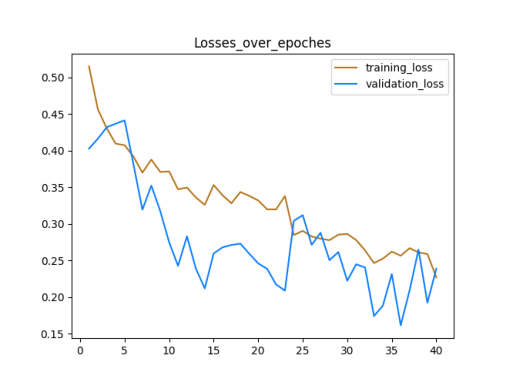

In [ ]:
show_losses()

The image we output is shown below:

Loading model from /content/drive/MyDrive/ckpt_Unet/unet_with_aspp/param.pth...


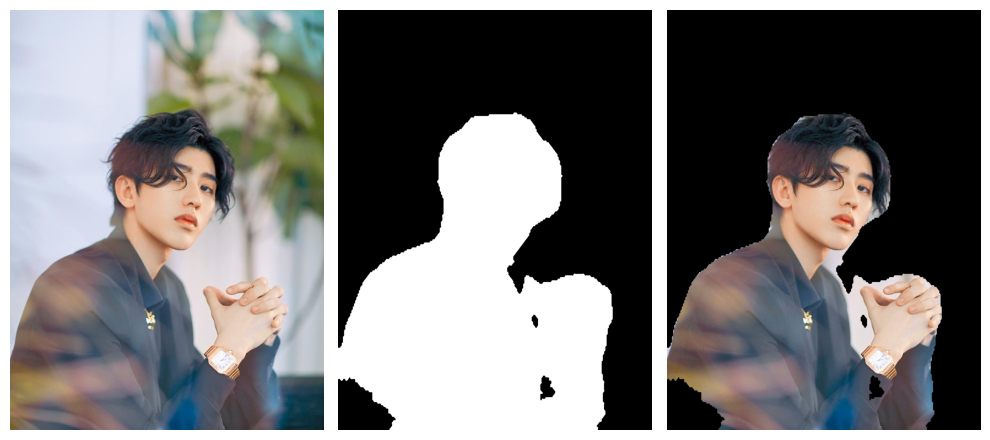

In [ ]:
unet_test_one_pic()

In [ ]:
test_unet_miou()

Loading model from /content/drive/MyDrive/ckpt_Unet/unet_with_aspp/param.pth...
Dataset : file number 100


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]

mIoU: 0.9132416042067133
Accuracy: 0.949030399648834


After testing, we got the final results based on U-Net model training with ASPP:

Test 4

mIoU: 0.9132416042067133

Accuracy: 0.949030399648834

In conclusion: numerically, we can find that the accuracy of the U-Net network model with ASPP applied is about 2% higher than that without it, which proves that the network model combining the hopping connection of UNet and the multi-scale sensory field of ASPP can take full advantage of the high-level features and global contextual information to improve the semantic segmentation performance. This model combines the advantages of both to improve mIoU and accuracy


# Utilising Unet_based_on_ASPP in Matting Network

We implement the "mv2_aspp_unet" module as our new Unet module, which combines the Unet with the ASPP module, this new Unet performs semantic segmentation and will generate a trimap, which classifies each pixel into three regions: background (bg), foreground (fg), and unsure (unsure) regions, then pass the result to the matting network.

In [ ]:
class Matting_net_aspp(nn.Module):


    def __init__(self):

        super(Matting_net_aspp, self).__init__()

        self.u_net = mv2_aspp_unet(3)
        self.m_net = M_net()
        #self.m_net=M_net_avrage_pool()


    def forward(self, input):

    	# trimap
        trimap = self.u_net(input)
        #trimap=F.interpolate(trimap, scale_factor=2, mode='bilinear', align_corners=False)
        trimap_softmax = F.softmax(trimap, dim=1)

        # paper: bs, fs, us
        bg, unsure, fg = torch.split(trimap_softmax, 1, dim=1)

        # concat input and trimap
        m_net_input = torch.cat((input, trimap_softmax), 1)

        # matting
        alpha_r = self.m_net(m_net_input)
        # fusion module
        # paper : alpha_p = fs + us * alpha_r
        alpha_p = fg + unsure * alpha_r

        return trimap, alpha_p

In [ ]:
torch.set_grad_enabled(True)
model=Matting_net_aspp()
matting_train(model)

=============> Loading args
============> Environment init
use CPU !
============> Building model ...
============> Loading datasets ...
Dataset : file number 999
Dataset : file number 100
============> Set optimizer ...
============> Start Train ! ...
============> Freeze Backbone ...


  0%|          | 1/499 [00:09<1:22:11,  9.90s/it]


KeyboardInterrupt: ignored

# Test & Result

After applying the Unet based on ASPP in Matting Network, we calculated the average validation loss for the training set and validation set as shown below:

In [ ]:
'''
class Matting_net_Test_args():
  def __init__(self):
    self.model='/content/drive/MyDrive/ckpt_shm/back_up/without_avg/ckpt_lastest_pretrain_Unet_maxpool_freeze_backbone &Tnet_40epoch.pth'
    self.loss_result='/content/drive/MyDrive/ckpt_shm/back_up/without_avg/Losses_over_epoches_pretrain_Unet_maxpool_freeze_backbone &Tnet_40epoch.png'
    self.size=256
    self.without_gpu=True
    self.pic_path='/content/drive/MyDrive/a.jpg'
    self.test_pic_path='/content/drive/MyDrive/test.txt'
    self.net=Matting_net()
'''
args=Matting_net_Test_args()
args.model='/content/drive/MyDrive/ckpt_shm/back_up/unet_with_aspp/ckpt_lastest.pth'
args.pic_path='/content/drive/MyDrive/gg.jpg'
args.loss_result='/content/drive/MyDrive/ckpt_shm/back_up/unet_with_aspp/Losses_over_epoches_with_aspp.png'
args.net=Matting_net_aspp()

here we show the losses over training 40 epoches


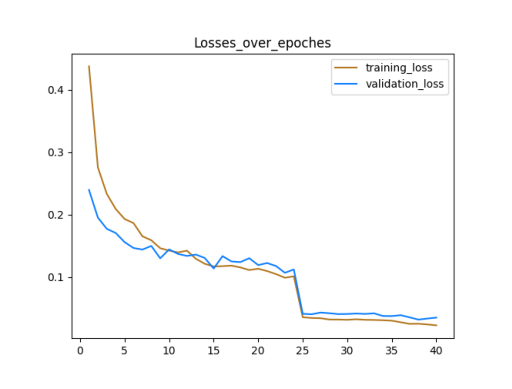

In [ ]:
show_losses()

The image we output is shown below:

Loading model from /content/drive/MyDrive/ckpt_shm/back_up/unet_with_aspp/ckpt_lastest.pth...


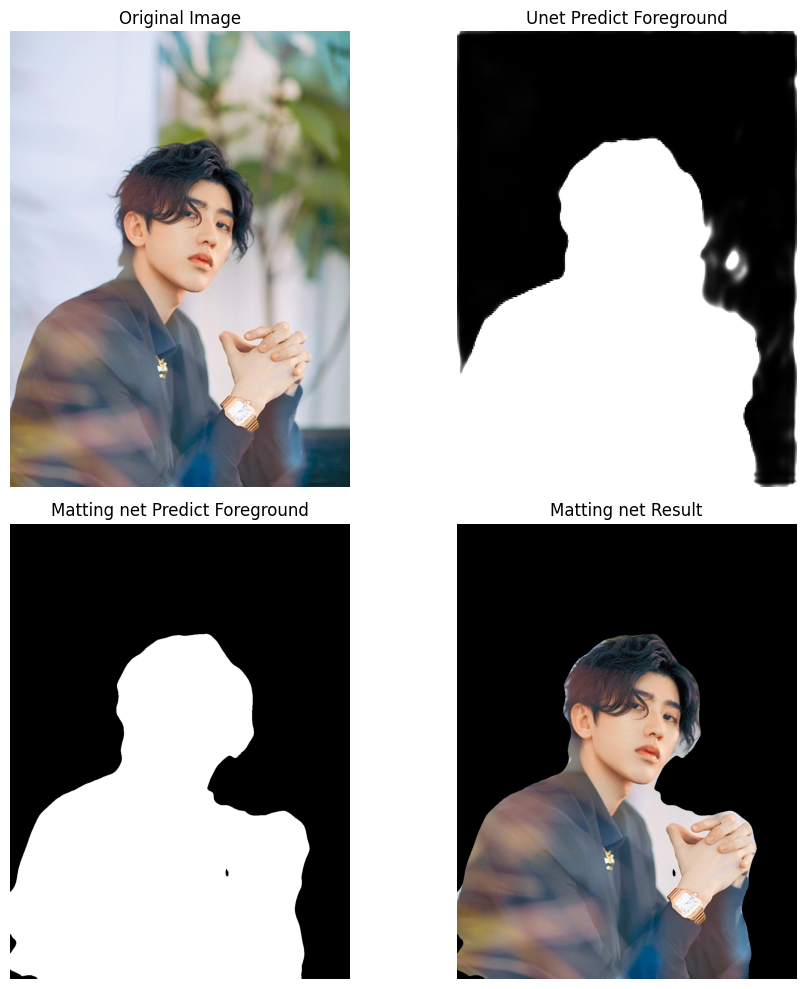

In [ ]:
test_one_pic()

In [ ]:
test_Matting_net_miou()

Loading model from /content/drive/MyDrive/ckpt_shm/back_up/unet_with_aspp/ckpt_lastest.pth...
Dataset : file number 100


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]

mIoU: 0.9310818119470126
Accuracy: 0.9639198170309408


After testing, we got the final results based on Matting Network (ASPP-based U-Net) model training :

Test 5

mIoU: 0.9310818119470126

Accuracy: 0.9639198170309408

In conclusion: numerically, we can find that applying ASPP's U-Net network model in matting network gives the best results with the highest mIoU and accuracy. This model fully combines the advantages of all three, making the network better for semantic segmentation and image-keying tasks. He brings the following advantages:
1. Multi-scale sensing field (ASPP): The ASPP module introduces hollow convolution with different sampling rates, which increases the network's ability to perceive the contextual information of images at different scales, and effectively ensures the accuracy and smoothness of keying.
2. Jump connection: The jump connection in the UNet structure enables the network to obtain information from different layers of features and fuse them in the decoder part. This feature is very favourable in the matting task, which improves the detail preservation ability of image keying.
3. Integrated feature: Matting network integrates the multi-scale receptive fields of ASPP and the jump connections of UNet, fully combining the advantages of both. Their combination can better deal with the problems of scale inconsistency and detail retention in the image keying task, which improves the accuracy and wholeness of the segmentation results.

# Comparison of 5 different models

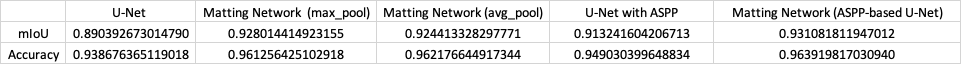

#sota(state of the art)

we attempted to replicate the SOTA ( so called State-of-the-Art) image segmentation network, which is currently considered the most advanced in this domain. However, after adjusting the parameters based on our existing network and training it for 40 epochs, the obtained results, as shown in the figure, were not as satisfactory as expected. I personally believe that this could be attributed to the fact that the SOTA network is designed for large-scale datasets, while our network exhibits advantages when dealing with smaller datasets.
Furthermore, the outcome might suggest the need for additional training epochs in the network architecture to adapt it better to our dataset. We aim to explore and fine-tune the network parameters further to achieve improved performance on our specific image segmentation task.
As for future improvement,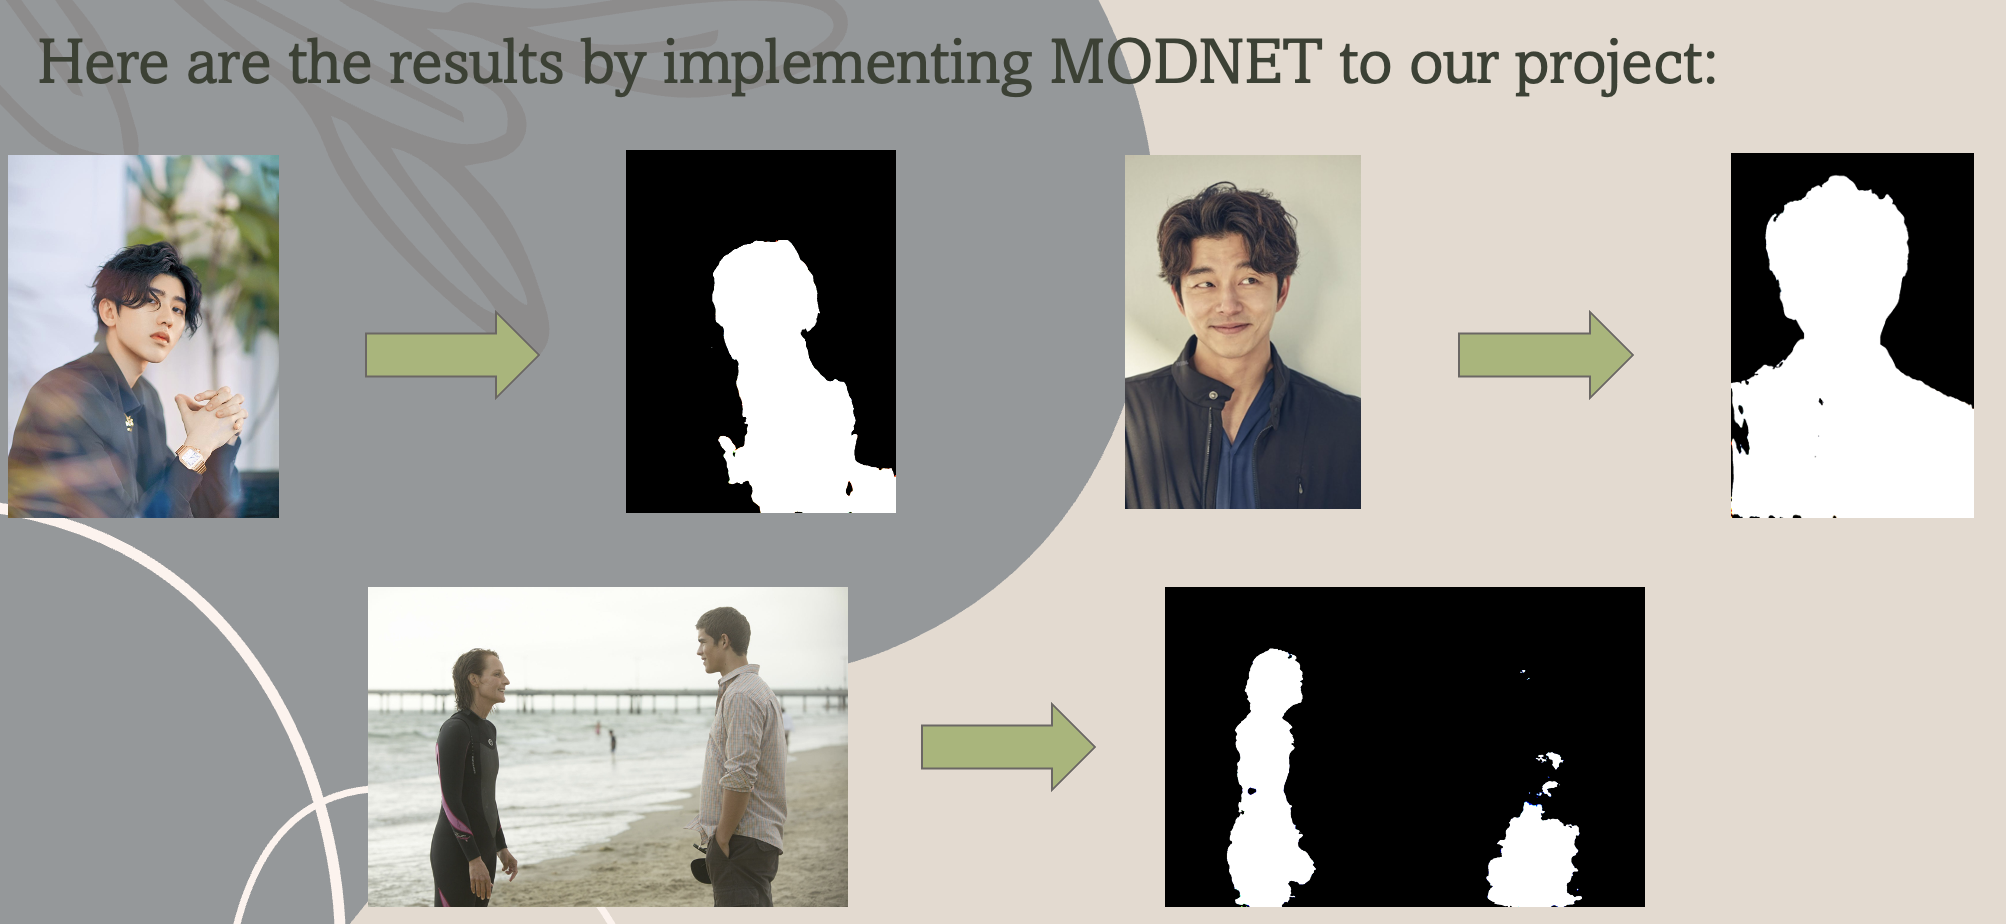

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from .backbones import SUPPORTED_BACKBONES


#------------------------------------------------------------------------------
#  MODNet Basic Modules
#------------------------------------------------------------------------------

class IBNorm(nn.Module):
    """ Combine Instance Norm and Batch Norm into One Layer
    """

    def __init__(self, in_channels):
        super(IBNorm, self).__init__()
        in_channels = in_channels
        self.bnorm_channels = int(in_channels / 2)
        self.inorm_channels = in_channels - self.bnorm_channels

        self.bnorm = nn.BatchNorm2d(self.bnorm_channels, affine=True)
        self.inorm = nn.InstanceNorm2d(self.inorm_channels, affine=False)

    def forward(self, x):
        bn_x = self.bnorm(x[:, :self.bnorm_channels, ...].contiguous())
        in_x = self.inorm(x[:, self.bnorm_channels:, ...].contiguous())

        return torch.cat((bn_x, in_x), 1)


class Conv2dIBNormRelu(nn.Module):
    """ Convolution + IBNorm + ReLu
    """

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, bias=True,
                 with_ibn=True, with_relu=True):
        super(Conv2dIBNormRelu, self).__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation,
                      groups=groups, bias=bias)
        ]

        if with_ibn:
            layers.append(IBNorm(out_channels))
        if with_relu:
            layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class SEBlock(nn.Module):
    """ SE Block Proposed in https://arxiv.org/pdf/1709.01507.pdf
    """

    def __init__(self, in_channels, out_channels, reduction=1):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, int(in_channels // reduction), bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(int(in_channels // reduction), out_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.pool(x).view(b, c)
        w = self.fc(w).view(b, c, 1, 1)

        return x * w.expand_as(x)


#------------------------------------------------------------------------------
#  MODNet Branches
#------------------------------------------------------------------------------

class LRBranch(nn.Module):
    """ Low Resolution Branch of MODNet
    """

    def __init__(self, backbone):
        super(LRBranch, self).__init__()

        enc_channels = backbone.enc_channels

        self.backbone = backbone
        self.se_block = SEBlock(enc_channels[4], enc_channels[4], reduction=4)
        self.conv_lr16x = Conv2dIBNormRelu(enc_channels[4], enc_channels[3], 5, stride=1, padding=2)
        self.conv_lr8x = Conv2dIBNormRelu(enc_channels[3], enc_channels[2], 5, stride=1, padding=2)
        self.conv_lr = Conv2dIBNormRelu(enc_channels[2], 1, kernel_size=3, stride=2, padding=1, with_ibn=False, with_relu=False)

    def forward(self, img, inference):
        enc_features = self.backbone.forward(img)
        enc2x, enc4x, enc32x = enc_features[0], enc_features[1], enc_features[4]

        enc32x = self.se_block(enc32x)
        lr16x = F.interpolate(enc32x, scale_factor=2, mode='bilinear', align_corners=False)
        lr16x = self.conv_lr16x(lr16x)
        lr8x = F.interpolate(lr16x, scale_factor=2, mode='bilinear', align_corners=False)
        lr8x = self.conv_lr8x(lr8x)

        pred_semantic = None
        if not inference:
            lr = self.conv_lr(lr8x)
            pred_semantic = torch.sigmoid(lr)

        return pred_semantic, lr8x, [enc2x, enc4x]


class HRBranch(nn.Module):
    """ High Resolution Branch of MODNet
    """

    def __init__(self, hr_channels, enc_channels):
        super(HRBranch, self).__init__()

        self.tohr_enc2x = Conv2dIBNormRelu(enc_channels[0], hr_channels, 1, stride=1, padding=0)
        self.conv_enc2x = Conv2dIBNormRelu(hr_channels + 3, hr_channels, 3, stride=2, padding=1)

        self.tohr_enc4x = Conv2dIBNormRelu(enc_channels[1], hr_channels, 1, stride=1, padding=0)
        self.conv_enc4x = Conv2dIBNormRelu(2 * hr_channels, 2 * hr_channels, 3, stride=1, padding=1)

        self.conv_hr4x = nn.Sequential(
            Conv2dIBNormRelu(3 * hr_channels + 3, 2 * hr_channels, 3, stride=1, padding=1),
            Conv2dIBNormRelu(2 * hr_channels, 2 * hr_channels, 3, stride=1, padding=1),
            Conv2dIBNormRelu(2 * hr_channels, hr_channels, 3, stride=1, padding=1),
        )

        self.conv_hr2x = nn.Sequential(
            Conv2dIBNormRelu(2 * hr_channels, 2 * hr_channels, 3, stride=1, padding=1),
            Conv2dIBNormRelu(2 * hr_channels, hr_channels, 3, stride=1, padding=1),
            Conv2dIBNormRelu(hr_channels, hr_channels, 3, stride=1, padding=1),
            Conv2dIBNormRelu(hr_channels, hr_channels, 3, stride=1, padding=1),
        )

        self.conv_hr = nn.Sequential(
            Conv2dIBNormRelu(hr_channels + 3, hr_channels, 3, stride=1, padding=1),
            Conv2dIBNormRelu(hr_channels, 1, kernel_size=1, stride=1, padding=0, with_ibn=False, with_relu=False),
        )

    def forward(self, img, enc2x, enc4x, lr8x, inference):
        img2x = F.interpolate(img, scale_factor=1/2, mode='bilinear', align_corners=False)
        img4x = F.interpolate(img, scale_factor=1/4, mode='bilinear', align_corners=False)

        enc2x = self.tohr_enc2x(enc2x)
        hr4x = self.conv_enc2x(torch.cat((img2x, enc2x), dim=1))

        enc4x = self.tohr_enc4x(enc4x)
        hr4x = self.conv_enc4x(torch.cat((hr4x, enc4x), dim=1))

        lr4x = F.interpolate(lr8x, scale_factor=2, mode='bilinear', align_corners=False)
        hr4x = self.conv_hr4x(torch.cat((hr4x, lr4x, img4x), dim=1))

        hr2x = F.interpolate(hr4x, scale_factor=2, mode='bilinear', align_corners=False)
        hr2x = self.conv_hr2x(torch.cat((hr2x, enc2x), dim=1))

        pred_detail = None
        if not inference:
            hr = F.interpolate(hr2x, scale_factor=2, mode='bilinear', align_corners=False)
            hr = self.conv_hr(torch.cat((hr, img), dim=1))
            pred_detail = torch.sigmoid(hr)

        return pred_detail, hr2x


class FusionBranch(nn.Module):
    """ Fusion Branch of MODNet
    """

    def __init__(self, hr_channels, enc_channels):
        super(FusionBranch, self).__init__()
        self.conv_lr4x = Conv2dIBNormRelu(enc_channels[2], hr_channels, 5, stride=1, padding=2)

        self.conv_f2x = Conv2dIBNormRelu(2 * hr_channels, hr_channels, 3, stride=1, padding=1)
        self.conv_f = nn.Sequential(
            Conv2dIBNormRelu(hr_channels + 3, int(hr_channels / 2), 3, stride=1, padding=1),
            Conv2dIBNormRelu(int(hr_channels / 2), 1, 1, stride=1, padding=0, with_ibn=False, with_relu=False),
        )

    def forward(self, img, lr8x, hr2x):
        lr4x = F.interpolate(lr8x, scale_factor=2, mode='bilinear', align_corners=False)
        lr4x = self.conv_lr4x(lr4x)
        lr2x = F.interpolate(lr4x, scale_factor=2, mode='bilinear', align_corners=False)

        f2x = self.conv_f2x(torch.cat((lr2x, hr2x), dim=1))
        f = F.interpolate(f2x, scale_factor=2, mode='bilinear', align_corners=False)
        f = self.conv_f(torch.cat((f, img), dim=1))
        pred_matte = torch.sigmoid(f)

        return pred_matte


#------------------------------------------------------------------------------
#  MODNet
#------------------------------------------------------------------------------

class MODNet(nn.Module):
    """ Architecture of MODNet
    """

    def __init__(self, in_channels=3, hr_channels=32, backbone_arch='mobilenetv2', backbone_pretrained=True):
        super(MODNet, self).__init__()

        self.in_channels = in_channels
        self.hr_channels = hr_channels
        self.backbone_arch = backbone_arch
        self.backbone_pretrained = backbone_pretrained

        self.backbone = SUPPORTED_BACKBONES[self.backbone_arch](self.in_channels)

        self.lr_branch = LRBranch(self.backbone)
        self.hr_branch = HRBranch(self.hr_channels, self.backbone.enc_channels)
        self.f_branch = FusionBranch(self.hr_channels, self.backbone.enc_channels)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                self._init_conv(m)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                self._init_norm(m)

        if self.backbone_pretrained:
            self.backbone.load_pretrained_ckpt()

    def forward(self, img, inference):
        pred_semantic, lr8x, [enc2x, enc4x] = self.lr_branch(img, inference)
        pred_detail, hr2x = self.hr_branch(img, enc2x, enc4x, lr8x, inference)
        pred_matte = self.f_branch(img, lr8x, hr2x)

        return pred_semantic, pred_detail, pred_matte

    def freeze_norm(self):
        norm_types = [nn.BatchNorm2d, nn.InstanceNorm2d]
        for m in self.modules():
            for n in norm_types:
                if isinstance(m, n):
                    m.eval()
                    continue

    def _init_conv(self, conv):
        nn.init.kaiming_uniform_(
            conv.weight, a=0, mode='fan_in', nonlinearity='relu')
        if conv.bias is not None:
            nn.init.constant_(conv.bias, 0)

    def _init_norm(self, norm):
        if norm.weight is not None:
            nn.init.constant_(norm.weight, 1)
            nn.init.constant_(norm.bias, 0)

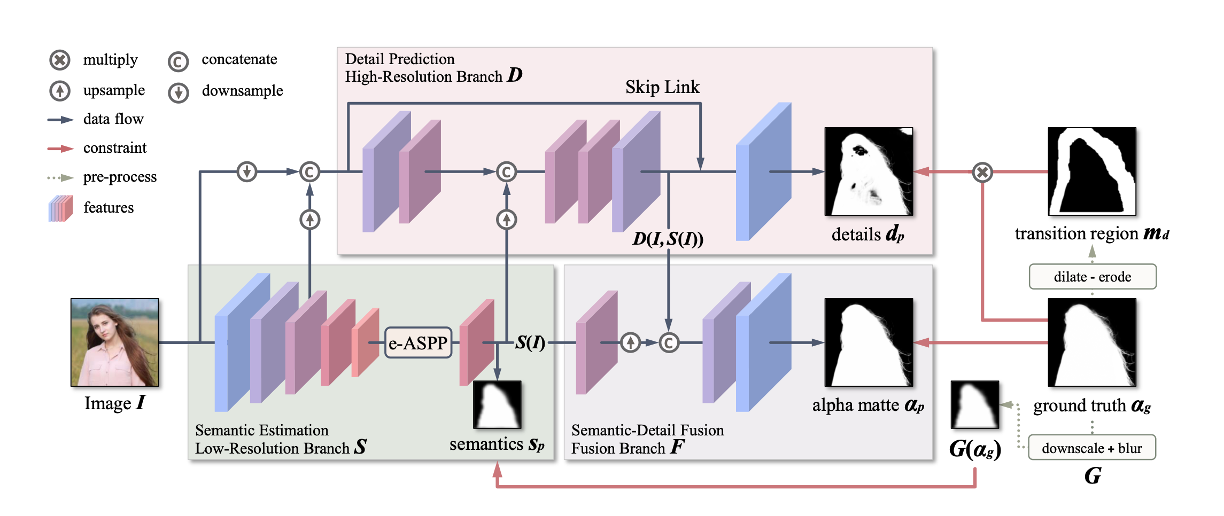